In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from scipy.linalg import norm
from IPython.display import clear_output
from IPython.utils import io
import random
from copy import deepcopy
from urllib import request
import tempfile
import gzip
from ast import literal_eval

from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

# from polara.lib.tensor import hooi
# from polara.lib.sparse import tensor_outer_at

from dataprep import transform_indices, full_preproccessing
from utils import topn_recommendations, downvote_seen_items, make_prediction, model_evaluate
# from RecVAE.utils import *
from RecVAE.model import VAE as RecVAE

In [2]:
def fix_torch_seed(seed, conv_determinism=True):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # settings below may affect computational performance
    # see https://pytorch.org/docs/stable/notes/randomness.html:
    if conv_determinism:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

def set_random_seed(seed):
#     torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    
# fix_torch_seed(42)
set_random_seed(42)

In [3]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda', index=0)

# Data preprocessing

In [6]:
# def amazon_data_reader(path):
#     with gzip.open(path, 'rt') as gz:
#         for line in gz:
#             yield literal_eval(line)

# def read_amazon_data(path=None, name=None):
#     '''Data is taken from https://jmcauley.ucsd.edu/data/amazon/'''
#     if path is None and name is None:
#             raise ValueError('Either the name of the dataset to download \
#                 or a path to a local file must be specified.')
#     if path is None:
#         file_url = f'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_{name}_5.json.gz'
#         print(f'Downloading data from: {file_url}')
#         with request.urlopen(file_url) as response:
#             file = response.read()
#             with tempfile.NamedTemporaryFile(delete=False) as temp:
#                 temp.write(file)
#                 path = temp.name
#                 print(f'Temporarily saved file at: {path}')
#     data = pd.DataFrame.from_records(
#         amazon_data_reader(path),
#         columns=['reviewerID', 'asin', 'overall', 'unixReviewTime']
#     )
#     data.to_csv(f'Amazon_{name}.csv', index=None)
#     return data

# data = read_amazon_data(name = "Video_Games")
# data.rename(columns = {'reviewerID' : 'userid', 'asin' : 'movieid', "overall" : "rating", "unixReviewTime" : "timestamp"}, inplace = True)

In [7]:
data = pd.read_csv('Amazon_Video_Games.csv')
data.rename(columns = {'reviewerID' : 'userid', 'asin' : 'movieid', "overall" : "rating", "unixReviewTime" : "timestamp"}, inplace = True)

In [8]:
training, testset_valid, holdout_valid, testset, holdout, data_description, data_index = full_preproccessing(data)

There are 24303 users
Filtered 17693 invalid observations.


In [9]:
del data

In [9]:
# alpha = 4
# a = training[training['rating']>=alpha][['userid', 'movieid']]
# a.columns = ['uid', 'sid']
# a.to_csv("train.csv", index=None)
# b = testset_valid[(testset_valid['rating']>=alpha)&(testset_valid['movieid'].isin(training['movieid']))][['userid', 'movieid']]
# b.columns = ['uid', 'sid']
# b.to_csv("validation_tr.csv", index=None)
# c = holdout_valid[(holdout_valid['rating']>=alpha)&(holdout_valid['movieid'].isin(training['movieid']))&(holdout_valid['userid'].isin(testset_valid['userid']))][['userid', 'movieid']]
# c.columns = ['uid', 'sid']
# c.to_csv("validation_te.csv", index=None)
# d = testset[(testset['rating']>=alpha)&(testset['movieid'].isin(training['movieid']))][['userid', 'movieid']]
# d.columns = ['uid', 'sid']
# d.to_csv("test_tr.csv", index=None)
# e = holdout[(holdout['rating']>=alpha)&(holdout['movieid'].isin(training['movieid']))&(holdout['userid'].isin(testset['userid']))][['userid', 'movieid']]
# e.columns = ['uid', 'sid']
# e.to_csv("test_te.csv", index=None)

# Baselines

## TopPop

In [26]:
def build_popularity_model(trainset, trainset_description):
    itemid = trainset_description['items']
    item_popularity = trainset[itemid].value_counts()
    return item_popularity

def popularity_model_scoring(params, testset, testset_description):
    item_popularity = params
    n_items = item_popularity.index.max() + 1
    n_users = testset_description['n_test_users']
    # fill in popularity scores for each item with indices from 0 to n_items-1
    popularity_scores = np.zeros(n_items,)
    popularity_scores[item_popularity.index] = item_popularity.values
    # same scores for each test user
    scores = np.tile(popularity_scores, n_users).reshape(n_users, n_items)
    return scores

## Normalized PureSVD

In [16]:
def matrix_from_observations(data, data_description):
    useridx = data[data_description['users']]
    itemidx = data[data_description['items']]
    values = data[data_description['feedback']]
    return csr_matrix((values, (useridx, itemidx)), shape=(useridx.values.max() + 1, data_description["n_items"]), dtype='f8')

def build_svd_model(config, data, data_description):
    source_matrix = matrix_from_observations(data, data_description)
    #print(source_matrix.shape)
    D = norm(source_matrix, axis=0)
    A = source_matrix.dot(diags(D**(config['f']-1)))
    _, _, vt = svds(A, k=config['rank'], return_singular_vectors='vh')
#     singular_values = s[::-1]
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors

def svd_model_scoring(params, data, data_description):
    item_factors = params
    test_data = data.assign(
        userid = pd.factorize(data['userid'])[0]
    )
    test_matrix = matrix_from_observations(test_data, data_description)
    #print(test_matrix.shape, item_factors.shape)
    scores = test_matrix.dot(item_factors) @ item_factors.T
    return scores

## EASEr

In [32]:
def matrix_from_observations(data, data_description):
    useridx = data[data_description['users']]
    itemidx = data[data_description['items']]
    values = data[data_description['feedback']]
    return csr_matrix((values, (useridx, itemidx)), shape=(useridx.values.max() + 1, data_description["n_items"]), dtype='f8')

def easer(data, data_description, lmbda=500):
    X = matrix_from_observations(data, data_description)
    G = X.T.dot(X)
    diag_indices = np.diag_indices(G.shape[0])
    G[diag_indices] += lmbda
    P = np.linalg.inv(G.A)
    B = P / (-np.diag(P))
    B[diag_indices] = 0
    
    return B

def easer_scoring(params, data, data_description):
    item_factors = params
    test_data = data.assign(
        userid = pd.factorize(data['userid'])[0]
    )
    test_matrix = matrix_from_observations(test_data, data_description)
    scores = test_matrix.dot(item_factors)
    return scores

## CoFFee

In [8]:
def tf_model_build(config, data, data_description):
    userid = data_description["users"]
    itemid = data_description["items"]
    feedback = data_description["feedback"]

    idx = data[[userid, itemid, feedback]].values
    idx[:, -1] = idx[:, -1] - data_description['min_rating'] # works only for integer ratings!
    val = np.ones(idx.shape[0], dtype='f8')
    
    n_users = data_description["n_users"]
    n_items = data_description["n_items"]
    n_ratings = data_description["n_ratings"]
    shape = (n_users, n_items, n_ratings)
    core_shape = config['mlrank']
    num_iters = config["num_iters"]
    
    u0, u1, u2, g = hooi(
        idx, val, shape, core_shape,
        num_iters=num_iters,
        parallel_ttm=False, growth_tol=0.01,
    )
    return u0, u1, u2
        

def tf_scoring(params, data, data_description):
    user_factors, item_factors, feedback_factors = params
    userid = data_description["users"]
    itemid = data_description["items"]
    feedback = data_description["feedback"]

    data = data.sort_values(userid)
    useridx = data[userid].values
    itemidx = data[itemid].values
    ratings = data[feedback].values
    ratings = ratings - data_description['min_rating'] # works only for integer ratings!
    
    tensor_outer = tensor_outer_at('cpu')
    # use the fact that test data is sorted by users for reduction:
    scores = tensor_outer(
        1.0,
        item_factors,
        feedback_factors,
        itemidx,
        ratings
    )
    scores = np.add.reduceat(scores, np.r_[0, np.where(np.diff(useridx))[0]+1])
    scores = np.tensordot(
        scores,
        feedback_factors[-1, :],
        axes=(2, 0)
    ).dot(item_factors.T)
    return scores

## Simple AE

In [10]:
class SimpleDataset(Dataset):
    def __init__(self, data, augment=False):
        self.data = data
        self.augment = augment

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        if self.augment:
            num_noise = np.random.randint(0, int(0.1*self.data.shape[1]))
            idxs = torch.randint(0, self.data.shape[1], size=(num_noise,))
            noised_input = self.data[idx].detach().clone().to_dense()
            noised_input[idxs] = torch.distributions.bernoulli.Bernoulli(0.5).sample(sample_shape=(num_noise,)).to(self.data.device)
            
            useridx = np.zeros_like(noised_input.cpu())
            itemidx = np.arange(self.data.shape[1])
            noised_input = torch.sparse_coo_tensor(np.array([itemidx,]), noised_input,
                                                   size=torch.Size((data_description["n_items"],)), dtype=torch.float32)
            return noised_input, self.data[idx]
        else:
            return self.data[idx], self.data[idx]

In [11]:
class baseAE(nn.Module):
    def __init__(self, n_items, hid):
        super(baseAE, self).__init__()
        self.V = nn.Linear(n_items, hid)
#         torch.nn.init.xavier_uniform_(self.V.weight)
        self.VT = nn.Linear(hid, n_items)
#         torch.nn.init.xavier_uniform_(self.VT.weight)
        self.relu = nn.ReLU()

    def forward(self, x):
        # encode
        x = self.V(x)
        x = self.relu(x)
        # decode
        output = self.VT(x)
#         output = self.relu(output)
        return output

## RecVAE

In [7]:
vae = RecVAE(600, 200, 1000)
sum(p.numel() for p in vae.parameters() if p.requires_grad)

2490400

# Tuning

## Normalized PureSVD

In [14]:
rank_grid = []
for i in range(5, 10):
    rank_grid.append(2 * 2 ** i)
    rank_grid.append(3 * 2 ** i)
    
rank_grid = np.array(rank_grid)

f_grid = np.linspace(0, 2, 21)

In [17]:
hr_tf = {}
mrr_tf = {}
grid = list(zip(np.meshgrid(rank_grid, f_grid)[0].flatten(), np.meshgrid(rank_grid, f_grid)[1].flatten()))
for params in tqdm(grid):
    r, f = params
    svd_config = {'rank': int(r), 'f': f}
    svd_params = build_svd_model(svd_config, training, data_description)
    svd_scores = svd_model_scoring(svd_params, testset_valid, data_description)
    downvote_seen_items(svd_scores, testset_valid, data_description)
    svd_recs = topn_recommendations(svd_scores, topn=10)
    hr, hr_pos, hr_neg, mrr, mrr_pos, mrr_neg, cov, C = model_evaluate(svd_recs, holdout_valid, data_description)
    hr_tf[f'r={r}, f={f:.2f}'] = hr
    mrr_tf[f'r={r}, f={f:.2f}'] = mrr

  0%|          | 0/210 [00:00<?, ?it/s]

MemoryError: Unable to allocate 903. KiB for an array with shape (115526,) and data type float64

## EASEr

In [9]:
lambda_grid = np.arange(10, 510, 10)

In [10]:
hr_tf = {}
mrr_tf = {}
for lmbda in tqdm(lambda_grid):
    easer_params = easer(training, data_description, lmbda=lmbda)
    easer_scores = easer_scoring(easer_params, testset_valid, data_description)
    downvote_seen_items(easer_scores, testset_valid, data_description)
    easer_recs = topn_recommendations(easer_scores, topn=10)
    hr, hr_pos, hr_neg, mrr, mrr_pos, mrr_neg, cov, C = model_evaluate(easer_recs, holdout_valid, data_description)
    hr_tf[lmbda] = hr
    mrr_tf[lmbda] = mrr

  0%|          | 0/50 [00:00<?, ?it/s]

In [14]:
{k: v for k, v in sorted(hr_tf.items(), key=lambda item: item[1])}

{10: 0.06382978723404255,
 20: 0.06758448060075094,
 30: 0.07108886107634543,
 40: 0.07459324155193993,
 50: 0.07659574468085106,
 60: 0.07909887359198998,
 80: 0.08035043804755945,
 70: 0.08110137672090113,
 90: 0.08110137672090113,
 110: 0.08110137672090113,
 100: 0.08160200250312892,
 120: 0.0818523153942428,
 130: 0.08235294117647059,
 140: 0.08260325406758448,
 150: 0.08310387984981227,
 160: 0.08310387984981227,
 170: 0.08385481852315395,
 180: 0.08485607008760951,
 190: 0.0853566958698373,
 200: 0.08610763454317898,
 210: 0.08660826032540676,
 220: 0.08685857321652066,
 350: 0.08710888610763455,
 360: 0.08710888610763455,
 370: 0.08710888610763455,
 280: 0.08735919899874844,
 290: 0.08735919899874844,
 340: 0.08735919899874844,
 390: 0.08735919899874844,
 260: 0.08760951188986234,
 270: 0.08760951188986234,
 320: 0.08760951188986234,
 330: 0.08760951188986234,
 380: 0.08760951188986234,
 240: 0.08785982478097622,
 250: 0.08785982478097622,
 300: 0.08785982478097622,
 400: 0.0878

## CoFFee

In [13]:
config = {
    "scaling": 1,
    "n_ratings": data_description['n_ratings'],
    "num_iters": 4,
    "params": None,
    "randomized": True,
    "growth_tol": 1e-4,
    "seed": 42
}

grid1 = 2**np.arange(4, 12)
grid2 = np.arange(2, 5)
grid = np.meshgrid(grid1, grid2)

In [12]:
hr_tf = {}
mrr_tf = {}
for r12, r3 in tqdm(zip(grid[0].flatten(), grid[1].flatten()), total=24):
    config['mlrank'] = (r12, r12, r3)
    tf_params = tf_model_build(config, training, data_description)
    tf_scores = tf_scoring(tf_params, testset_valid, data_description)
    downvote_seen_items(tf_scores, testset_valid, data_description)
    tf_recs = topn_recommendations(tf_scores, topn=10)
    hr, hr_pos, hr_neg, mrr, mrr_pos, mrr_neg, cov, C = model_evaluate(tf_recs, holdout_valid, data_description)
    hr_tf[(r12, r3)] = hr
    mrr_tf[(r12, r3)] = mrr

  0%|          | 0/24 [00:00<?, ?it/s]

growth of the core: 1.0
growth of the core: 0.17108376145578136
growth of the core: 0.013724276626127477
growth of the core: 0.002121752668025982
Done
growth of the core: 1.0
growth of the core: 0.1944648491989059
growth of the core: 0.02467704747273349
growth of the core: 0.005981755700370528
Done
growth of the core: 1.0
growth of the core: 0.16282144181882102
growth of the core: 0.029912952116613767
growth of the core: 0.013916498704220537
Done
growth of the core: 1.0
growth of the core: 0.23035313236669488
growth of the core: 0.034784826568450604
growth of the core: 0.011006067169166954
Done
growth of the core: 1.0
growth of the core: 0.17594728189169354
growth of the core: 0.030919135038606764
growth of the core: 0.008959802437981649
Done
growth of the core: 1.0
growth of the core: 0.1619910003475919
growth of the core: 0.025820893734533307
growth of the core: 0.008684790230411127
Done
growth of the core: 1.0
growth of the core: 0.19297251628357556
growth of the core: 0.01668695007

In [13]:
hr_tf

{(16, 2): 0.05102639296187683,
 (32, 2): 0.05689149560117302,
 (64, 2): 0.06099706744868035,
 (128, 2): 0.05337243401759531,
 (256, 2): 0.06862170087976541,
 (512, 2): 0.031085043988269796,
 (1024, 2): 0.021114369501466276,
 (2048, 2): 0.008211143695014663,
 (16, 3): 0.04868035190615835,
 (32, 3): 0.04574780058651026,
 (64, 3): 0.052785923753665684,
 (128, 3): 0.047507331378299114,
 (256, 3): 0.04105571847507332,
 (512, 3): 0.03284457478005865,
 (1024, 3): 0.01818181818181818,
 (2048, 3): 0.004105571847507331,
 (16, 4): 0.04281524926686217,
 (32, 4): 0.04574780058651026,
 (64, 4): 0.04926686217008798,
 (128, 4): 0.0469208211143695,
 (256, 4): 0.0404692082111437,
 (512, 4): 0.03167155425219941,
 (1024, 4): 0.01935483870967742,
 (2048, 4): 0.004105571847507331}

## Simple AE

In [12]:
useridx = training[data_description['users']].values
itemidx = training[data_description['items']].values
values = np.ones(len(itemidx))

In [13]:
user_tensor_train = torch.sparse_coo_tensor(np.array([useridx, itemidx]), torch.tensor(values),
                              size=torch.Size((data_description["n_users"], data_description["n_items"])), dtype=torch.float32).to_dense().to(device)

In [14]:
grid = 2**np.arange(2, 11)

In [16]:
def prepare_tensor(data, data_description):
    useridx = pd.factorize(data[data_description['users']])[0]
    itemidx = data[data_description['items']].values
    values = np.ones(len(itemidx), dtype=np.float32)
    user_tensor_test = torch.sparse_coo_tensor(np.array([useridx, itemidx]), torch.tensor(values),
                                      size=torch.Size((data[data_description['users']].nunique(), data_description["n_items"])))
    return user_tensor_test

In [23]:
def predict_and_check(scores, holdout, data_description, hrs, mrrs, cs, ndcgs, alpha, prev_matt, epoch, disp=False, dcg=True):
    mrr10, hr10, c10, ndcg10 = make_prediction(scores, holdout, data_description, disp=disp, dcg=dcg, alpha=alpha)
    hrs.append(hr10)
    mrrs.append(mrr10)
    cs.append(c10)
    ndcgs.append(ndcg10)

    if np.max(prev_matt) < cs[-1] or epoch == 1:
        prev_matt = [cs[-1]]
        torch.save(bae.state_dict(), f'best_bae_{h}_{alpha}.pt')
#     elif prev_matt[-1] < cs[-1]:
#         prev_matt = [cs[-1]]
    else:
        prev_matt.append(cs[-1])
        
    return prev_matt

In [18]:
def check_test(bae, criterion, user_tensor_test, testset, holdout, data_description, test_num_batches, alpha, batch_size=16, dcg=True):
    test_loss = 0
    scores = torch.zeros((testset.userid.nunique(), data_description['n_items']))
    
    bae.load_state_dict(torch.load(f'best_bae_{h}_{alpha}.pt'))
    with torch.no_grad():
        for batch in range(test_num_batches):
            input_tensor = user_tensor_test[batch * batch_size: (batch+1) * batch_size].to(device)
            target = input_tensor.clone()

            output = bae(input_tensor)
            target.require_grad = False

            test_loss += criterion(output, target)
            scores[batch * batch_size: (batch+1) * batch_size] = output

    test_loss = test_loss / test_num_batches
    scores = scores.detach().cpu().numpy()
    downvote_seen_items(scores, testset, data_description)
    print(f'Results for alpha={alpha}')
    make_prediction(scores, holdout, data_description, dcg=dcg, alpha=alpha)

  0%|          | 0/9 [00:00<?, ?it/s]

Hidden sizes: 4


C:\Users\Liza\Desktop\Thesis\utils.py:71: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))
C:\Users\Liza\Desktop\Thesis\utils.py:71: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))
C:\Users\Liza\Desktop\Thesis\utils.py:71: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))
C:\Users\Liza\Desktop\Thesis\utils.py:71: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))


Current epoch 96
Results for alpha=2


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010038  0.003519    0.002322  0.00514  0.009491  0.000548   0.003307   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000213    0.004843    0.000298   -0.001317

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.012776  0.003855     0.003836  0.005995   0.012229   0.000548   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.003642    0.000213     0.005697     0.000298      0.00452

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020989  0.00439      0.00636  0.008029   0.020259    0.00073   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.004165    0.000225     0.007686     0.000343      0.01116

Results for alpha=3


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010038  0.003519    0.002322  0.00514  0.008761  0.001278   0.003048   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000471    0.004466    0.000674   -0.009701

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.012776  0.003855     0.003836  0.005995   0.011498   0.001278   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.003383    0.000471     0.005321     0.000674     -0.00055

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020989  0.00439      0.00636  0.008029   0.019347   0.001643   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.003893    0.000498     0.007262     0.000768     0.009971

Results for alpha=4


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010038  0.003519    0.002322  0.00514  0.008761  0.001278   0.003048   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000471    0.004466    0.000674    0.019693

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.012776  0.003855     0.003836  0.005995   0.010951   0.001825   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.003326    0.000528     0.005161     0.000834     0.017867

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.020989  0.00439      0.00636  0.008029   0.018434   0.002555   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.003808    0.000582     0.007006     0.001023     0.030636

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010038  0.006075    0.000909  0.007072  0.008396  0.001643   0.005086   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000989    0.005918    0.001154    0.047652

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.012229  0.006342     0.002221  0.007755   0.010221   0.002008   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.005305    0.001037     0.006483     0.001272     0.052528

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.023909  0.00707     0.003937  0.010606   0.018434   0.005475   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.005804    0.001266     0.008471     0.002135     0.053133

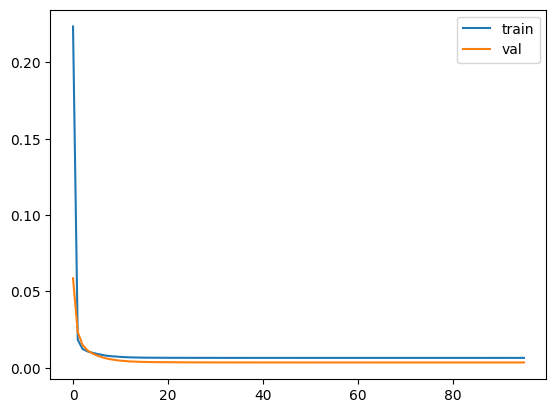

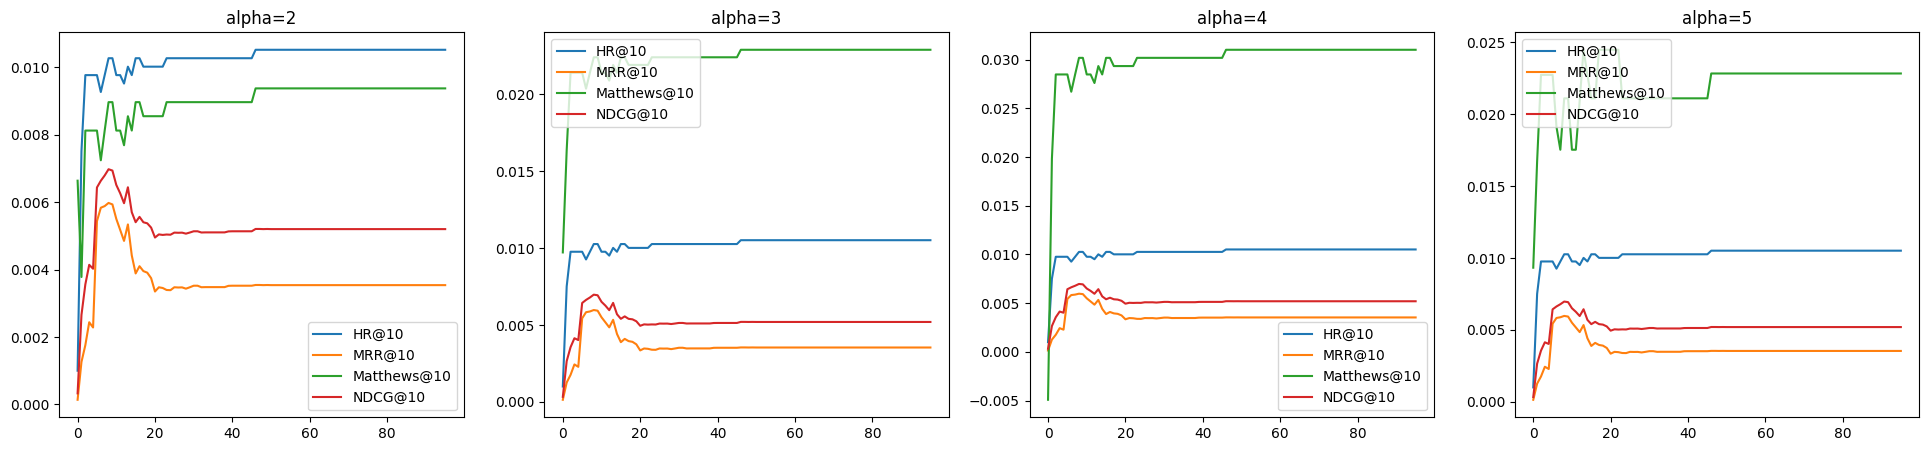

Test loss: 0.003430837532505393
Train loss: 0.006428044542833203


Hidden sizes: 8
Current epoch 98
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010951  0.004928    0.004946  0.006425  0.010403  0.000548   0.004715   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000213    0.006128    0.000298    0.000785

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.016061  0.005561     0.007369  0.008029   0.015331    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.005328    0.000233     0.007677     0.000353     0.003577

HR@20    MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  \
20  0.025005  0.006175     0.012114  0.01028   0.023727   0.001278   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.005907    0.000268     0.009793     0.000487     0.000403

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010951  0.004928    0.004946  0.006425  0.009673  0.001278   0.004426   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000502    0.005727    0.000698   -0.006393

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.016061  0.005561     0.007369  0.008029   0.014601    0.00146   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.005039    0.000522     0.007277     0.000753     0.003279

HR@20    MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  \
20  0.025005  0.006175     0.012114  0.01028   0.022814    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.005605     0.00057     0.009346     0.000934     0.005892

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010951  0.004928    0.004946  0.006425  0.009673  0.001278   0.004426   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000502    0.005727    0.000698    0.023335

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.016061  0.005561     0.007369  0.008029   0.014236   0.001825   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.004995    0.000567     0.007163     0.000866      0.02929

HR@20    MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  \
20  0.025005  0.006175     0.012114  0.01028   0.021902   0.003103   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.005523    0.000652     0.009094     0.001186     0.032578

Results for alpha=5


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.001825  0.00111    0.001009  0.001287  0.001278  0.000548     0.0007   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000411    0.000844    0.000444    0.008307

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.011681  0.002466     0.002019  0.004519   0.009856   0.001825   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.001876     0.00059     0.003653     0.000866     0.053088

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.015514  0.002715     0.003533  0.005466   0.012594    0.00292   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.002058    0.000657     0.004334     0.001132     0.053086

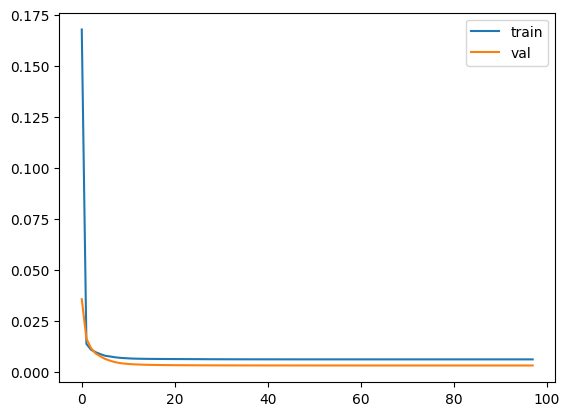

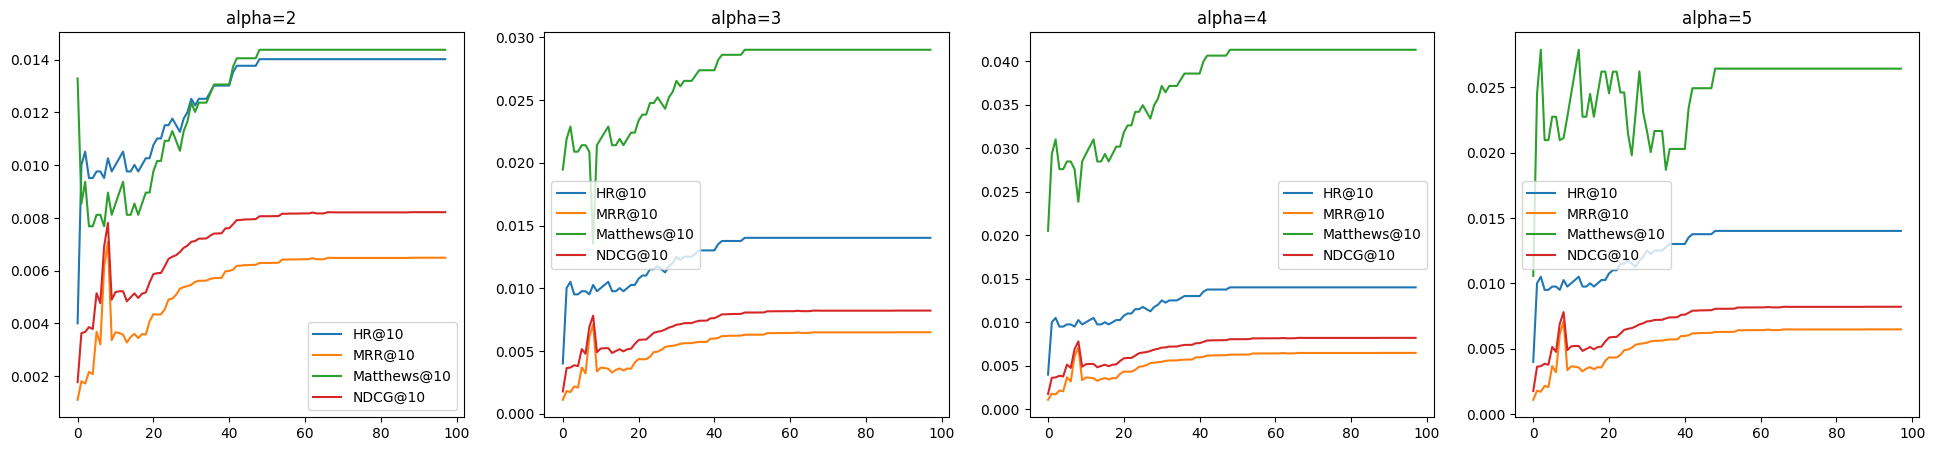

Test loss: 0.0033085292670875788
Train loss: 0.006299777842496826


Hidden sizes: 16
Current epoch 87
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.014784  0.007115    0.006461  0.009039  0.014236  0.000548   0.006887   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000228     0.00873    0.000309    0.008089

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.020989  0.007964     0.010398  0.011067   0.020077   0.000913   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10     0.00769    0.000274     0.010643     0.000424     0.005407

HR@20   MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.03267  0.00875      0.01595  0.01399   0.031028   0.001643     0.00843   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000319     0.013387     0.000603      0.00114

Results for alpha=3


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010951  0.007699    0.002827  0.00852  0.009673  0.001278   0.006893   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000806    0.007596    0.000924   -0.006393

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  \
10  0.016244  0.008415      0.00535  0.01024   0.014601   0.001643   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.007559    0.000857     0.009197     0.001044    -0.001106

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.027195  0.009158     0.007874  0.012987   0.025187   0.002008   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008278    0.000879     0.011855     0.001132     0.013873

Results for alpha=4


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.013506  0.007024    0.009085  0.00863  0.012046   0.00146    0.00609   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000934    0.007568    0.001062    0.028423

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.019894  0.007859     0.013527  0.010677   0.017704    0.00219   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.006838    0.001021      0.00939     0.001287      0.03391

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.035043  0.008874     0.020493  0.014461    0.03048   0.004563   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.007691    0.001184     0.012576     0.001885     0.035885

Results for alpha=5


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.013871  0.00685    0.004946  0.008617  0.010403  0.003468   0.005372   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001478    0.006641    0.001977     0.03517

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.020624  0.007756     0.007672  0.010806   0.015879   0.004745   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.006116    0.001641     0.008424     0.002382     0.048944

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.03048  0.008409     0.011912  0.013258   0.023909   0.006571   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20     0.00665    0.001759     0.010425     0.002833     0.065068

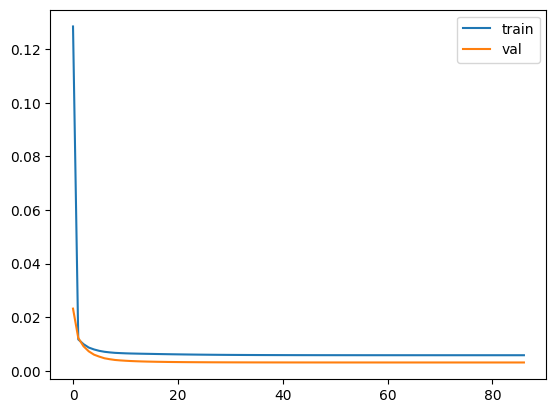

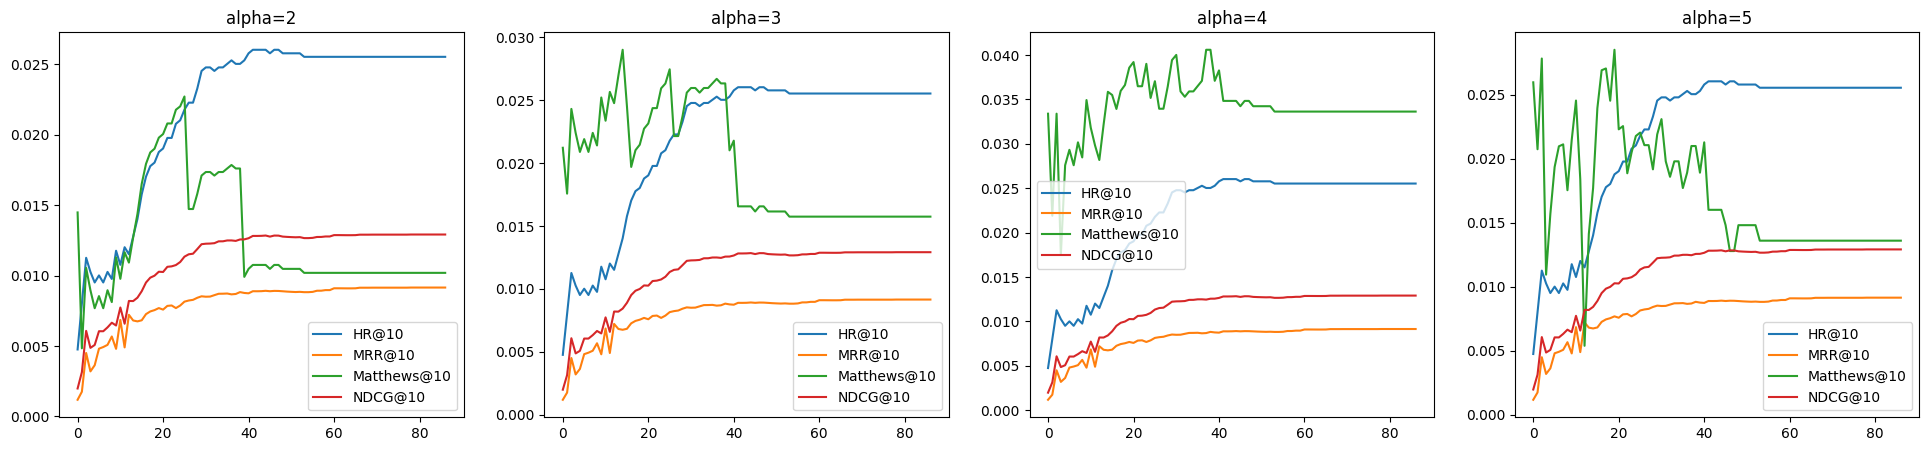

Test loss: 0.0031416749116033316
Train loss: 0.005884776242702005


Hidden sizes: 32
Current epoch 104
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.023727  0.014206    0.024228  0.016574  0.022814  0.000913   0.013521   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000684    0.015833    0.000741    0.009291

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.036138  0.015829     0.033111  0.020554    0.03486   0.001278   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.015084    0.000745     0.019683     0.000871     0.014259

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.05731  0.017291      0.04684  0.025898   0.055485   0.001825   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.016507    0.000784     0.024887      0.00101     0.022063

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.011863  0.006887    0.002928  0.008149  0.010586  0.001278   0.006263   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000624     0.00736    0.000789   -0.003358

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.018799  0.007777     0.005047  0.010355   0.016974   0.001825   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.007082    0.000695     0.009391     0.000964     0.000683

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.034495  0.00883     0.008278  0.014281   0.032488   0.002008   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008122    0.000708      0.01327     0.001011     0.025592

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.023727  0.014206    0.024228  0.016574  0.020077   0.00365   0.012283   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001922    0.014228    0.002346    0.020252

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.036138  0.015829     0.033111  0.020554   0.030845   0.005293   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.013663    0.002166     0.017652     0.002902     0.028685

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.05731  0.017291      0.04684  0.025898   0.048914   0.008396   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.014912    0.002379     0.022215     0.003682     0.036508

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.024275  0.014461    0.024732  0.016898  0.017339  0.006936   0.010577   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.003885    0.012265    0.004633     0.03525

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.036503  0.016084     0.033717  0.020843     0.0261   0.010403   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.011739    0.004345     0.015092     0.005751     0.043784

HR@20    MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.05804  0.017572     0.048254  0.02628   0.040883   0.017156     0.01277   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.004802     0.018836     0.007444     0.050456

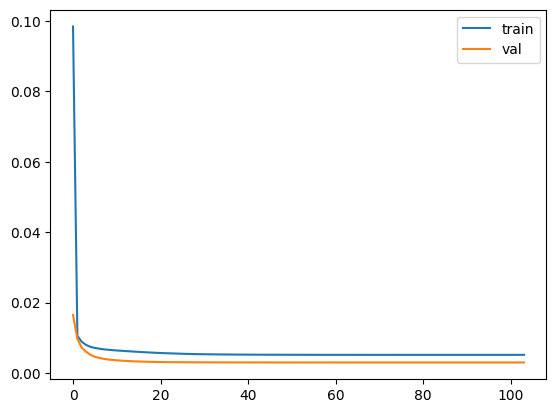

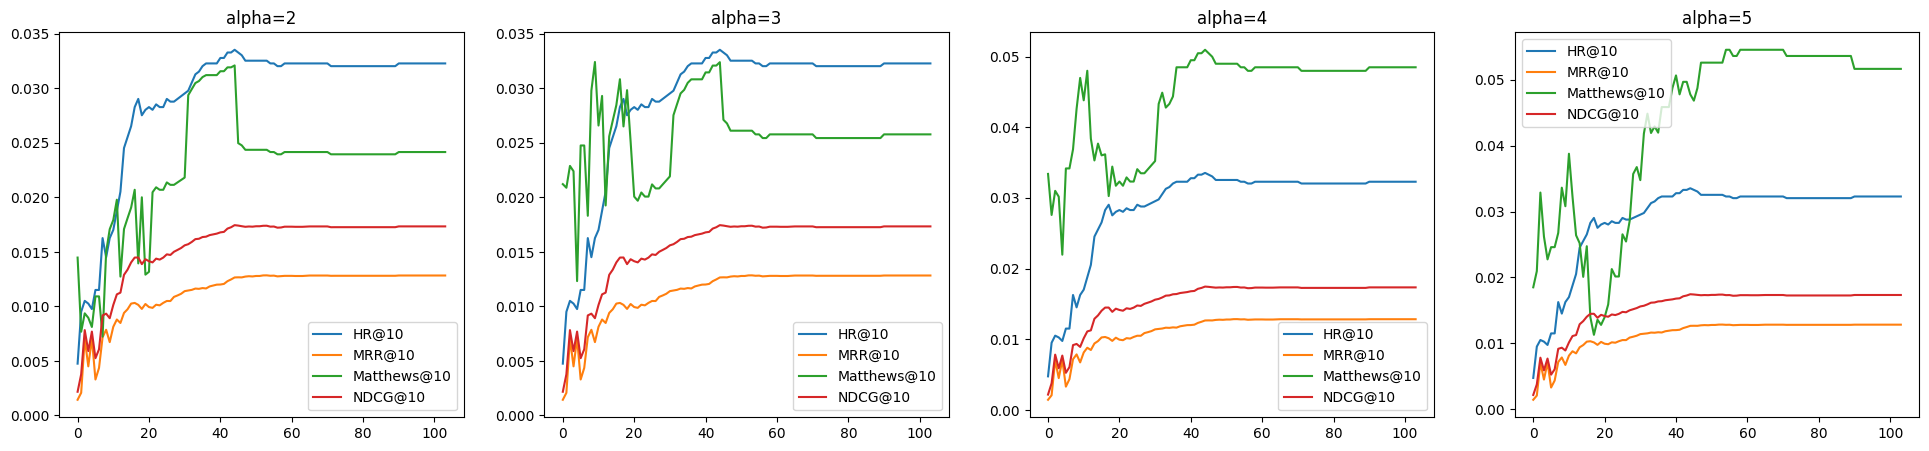

Test loss: 0.0029591263737529516
Train loss: 0.005137081167752315


Hidden sizes: 64
Current epoch 68
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.02975  0.016886    0.027559  0.020047  0.028837  0.000913   0.016454   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000432    0.019496    0.000551    0.016596

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.046176  0.019105     0.039572  0.025387   0.044534   0.001643   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.018563    0.000542     0.024588     0.000799     0.015984

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.069173  0.020658     0.059863  0.031149   0.066983    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.020077    0.000581     0.030209      0.00094     0.024621

Results for alpha=3


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.019347  0.011648    0.008076  0.01355  0.017886   0.00146   0.010607   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00104    0.012404    0.001146    0.010879

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.035773  0.013832     0.012518  0.018856    0.03413   0.001643   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.012772    0.001061     0.017655     0.001201     0.034016

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.052017  0.014959      0.01918  0.022962   0.048549   0.003468   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.013762    0.001197     0.021288     0.001675     0.025063

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.029567  0.016575    0.024833  0.019749   0.02537  0.004198   0.014629   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001947    0.017252    0.002497    0.027795

HR@10   MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.045811  0.01872      0.03614  0.024979   0.039423   0.006388   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.016493    0.002227     0.021786     0.003193     0.036262

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.068261  0.020275     0.054008  0.030651   0.057857   0.010403   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.017776    0.002499     0.026451       0.0042     0.036125

Results for alpha=5


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.019347  0.011648    0.008076  0.01355  0.015149  0.004198   0.009031   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.002616    0.010548    0.003002    0.051139

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.035773  0.013832     0.012518  0.018856   0.028107   0.007666   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10     0.01077    0.003062     0.014749     0.004107      0.07119

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.052017  0.014959      0.01918  0.022962   0.039788   0.012229   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.011584    0.003375     0.017707     0.005255     0.076609

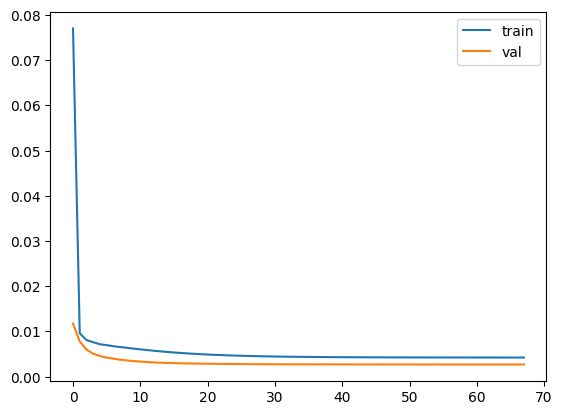

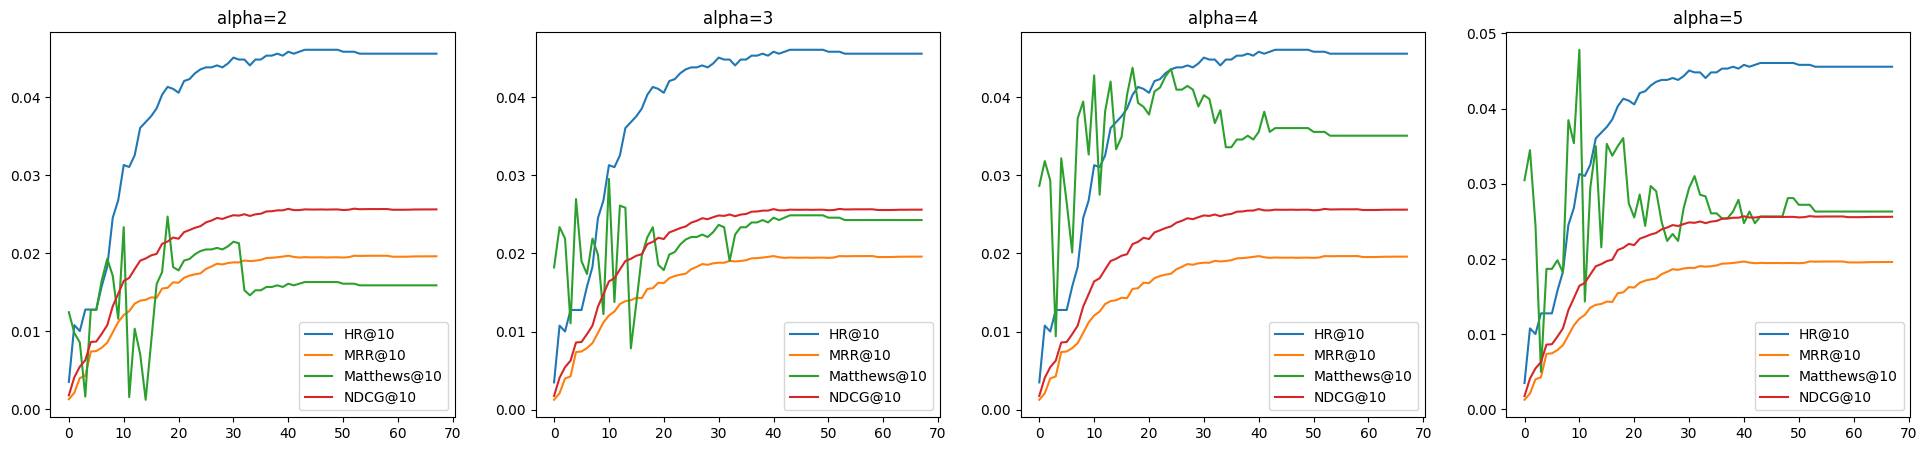

Test loss: 0.002873032120987773
Train loss: 0.005025594380943338


Hidden sizes: 128
Current epoch 72
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.017521  0.010832    0.006562  0.012487  0.016791   0.00073    0.01033   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000502    0.011928    0.000559    0.006025

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.026465  0.012001     0.009691  0.015354   0.025552   0.000913   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.011469    0.000532      0.01473     0.000624      0.01279

HR@20    MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  \
20  0.045081  0.013219     0.016354  0.01997   0.043986   0.001095   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.012675    0.000545       0.0193     0.000669      0.02686

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.017521  0.010832    0.006562  0.012487  0.016244  0.001278   0.009874   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000958    0.011448    0.001039    0.011488

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.026465  0.012001     0.009691  0.015354    0.02464   0.001825   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.010964    0.001038     0.014131     0.001222     0.016369

HR@20    MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  \
20  0.045081  0.013219     0.016354  0.01997   0.042161    0.00292   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.012111    0.001108     0.018477     0.001493     0.024625

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.040883  0.024183    0.091964  0.028302  0.035955  0.004928   0.021166   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.003018    0.024817    0.003485    0.043813

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.064245  0.027246     0.126186  0.035801   0.054755   0.009491   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10     0.02368    0.003566     0.030901       0.0049        0.038

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.099653  0.02971     0.172421  0.044761   0.083409   0.016244   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.025663    0.004047     0.038137     0.006623     0.035691

Results for alpha=5


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.020807  0.010212    0.002423  0.01285  0.016974  0.003833   0.008645   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001567    0.010731    0.002119    0.062845

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  MRR_pos@10  \
10  0.0261  0.010938     0.004341  0.014581   0.019894   0.006206     0.00904   

    MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.001898      0.01168     0.002901     0.052643

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.035773  0.011589     0.007571  0.017002    0.02756   0.008213   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.009551    0.002038     0.013592      0.00341     0.065159

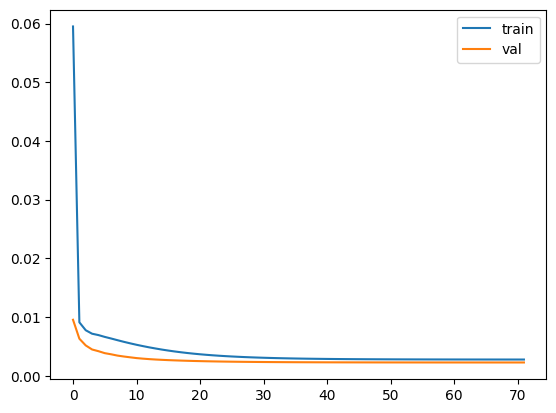

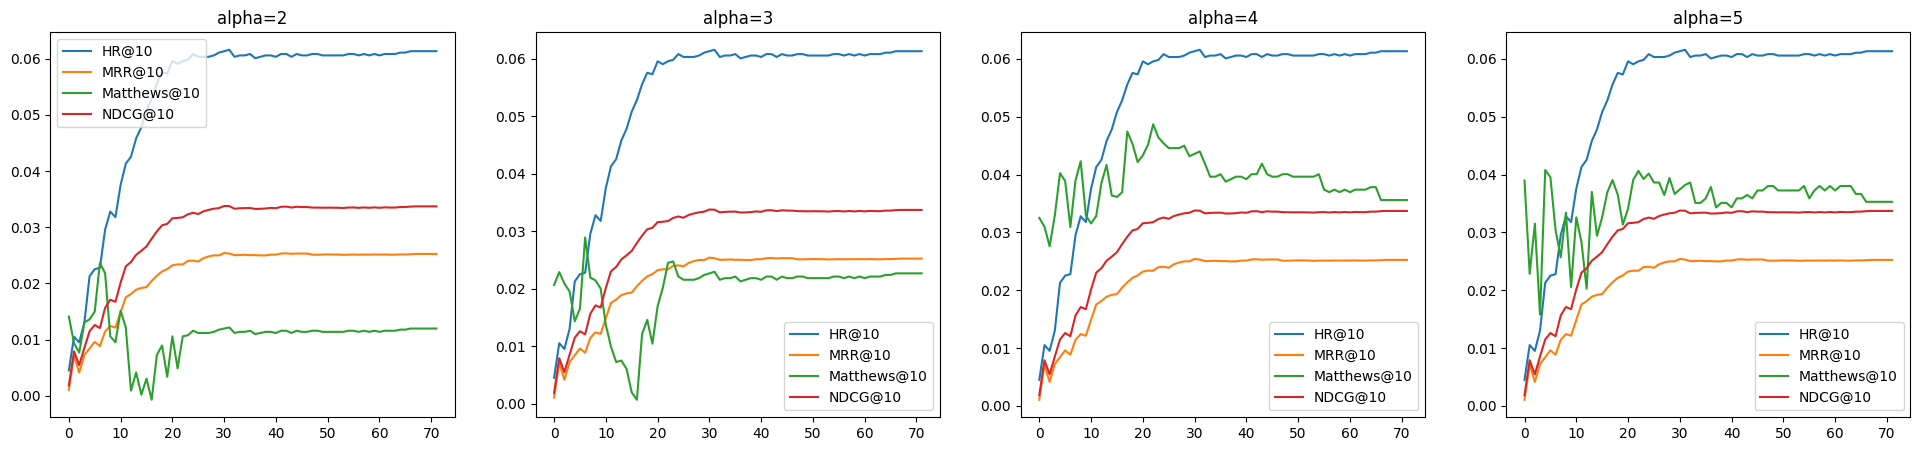

Test loss: 0.0024507350753992796
Train loss: 0.0034875836003263948


Hidden sizes: 256
Current epoch 60
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.039241  0.022072    0.047143  0.026309  0.038328  0.000913   0.021342   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00073    0.025531    0.000778    0.025929

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.061143  0.024884     0.067636  0.033279     0.0595   0.001643   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.024067    0.000817     0.032275     0.001004     0.028579

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.086147  0.026549     0.095901  0.039513   0.083592   0.002555   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.025672    0.000878     0.038282     0.001231     0.030507

Results for alpha=3


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.038328  0.022449    0.058954  0.02638  0.035955  0.002373   0.021135   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001314    0.024802    0.001577     0.02455

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.060778  0.025395     0.086109  0.033589    0.05731   0.003468   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10     0.02393    0.001465     0.031653     0.001936     0.035419

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.092535  0.027573      0.12124  0.041587   0.086877   0.005658   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20     0.02595    0.001622     0.039091     0.002497     0.040083

Results for alpha=4


HR@5     MRR@5  Coverage@5   NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.038328  0.022449    0.058954  0.02638  0.033035  0.005293   0.020171   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.002278    0.023367    0.003013    0.033704

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.060778  0.025395     0.086109  0.033589   0.052382   0.008396   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.022685     0.00271     0.029555     0.004033     0.042919

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.092535  0.027573      0.12124  0.041587   0.079394   0.013141   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.024536    0.003037     0.036356     0.005231      0.05082

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.039241  0.022072    0.047143  0.026309  0.030297  0.008943   0.017552   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00452    0.020703    0.005605    0.069064

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.061143  0.024884     0.067636  0.033279   0.043986   0.017156   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.019335    0.005549     0.025086     0.008193     0.059703

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.086147  0.026549     0.095901  0.039513   0.062055   0.024092   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.020544    0.006005     0.029598     0.009915     0.072418

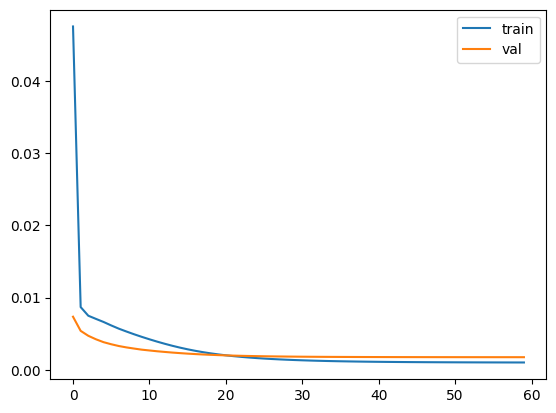

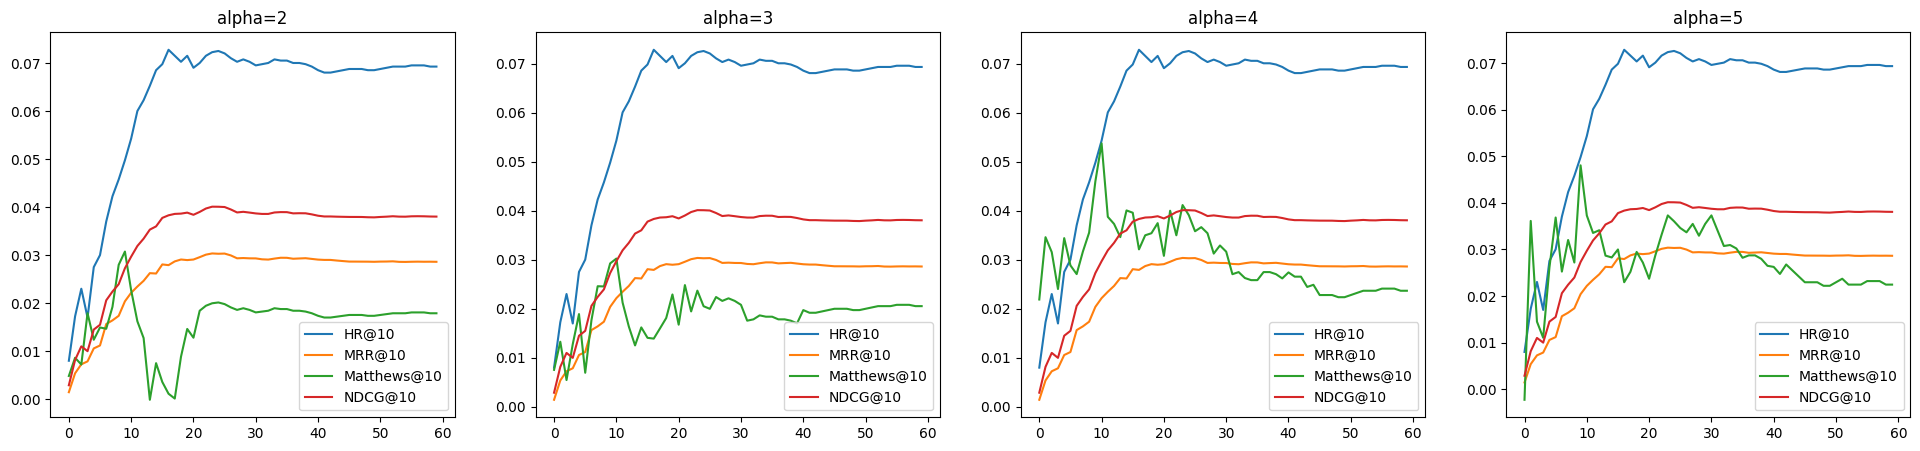

Test loss: 0.002673535840585828
Train loss: 0.00422065844815926


Hidden sizes: 512
Current epoch 73
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.043621  0.026589    0.424389  0.030785  0.041613  0.002008   0.025473   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001116    0.029445     0.00134    0.005429

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.06096  0.028879     0.549768  0.036365   0.058587   0.002373   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.027724    0.001155     0.034917     0.001448     0.014654

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.086695  0.030644     0.677064  0.042846   0.083592   0.003103   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.029439    0.001205     0.041215     0.001632     0.022081

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.043986  0.026811      0.4149  0.031049  0.040153  0.003833   0.024296   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.002516    0.028201    0.002848    0.008219

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.061325  0.029066     0.540481  0.036595   0.056397   0.004928   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.026421    0.002645     0.033409     0.003186     0.015608

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.086877  0.030823     0.667373  0.043038   0.080124   0.006753   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.028058    0.002765     0.039399     0.003639     0.021553

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.050192  0.029038     0.19362  0.034238  0.041978  0.008213   0.024761   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.004277    0.029006    0.005232    0.024302

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.075014  0.032249     0.264587  0.042164    0.06242   0.012594   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.027405    0.004844     0.035534     0.006631     0.027118

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.110604  0.034645     0.347466  0.051071   0.091988   0.018617   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.029401    0.005244      0.04294     0.008131     0.033203

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.020259  0.011763    0.006663  0.013819  0.015696  0.004563   0.009524   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.002239    0.011019      0.0028     0.04993

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.039971  0.014484     0.009893  0.020283    0.03048   0.009491   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10      0.0116    0.002884     0.015901     0.004382      0.06575

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.05585  0.015561     0.016657  0.024268   0.042343   0.013506   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.012407    0.003154     0.018881     0.005387     0.076188

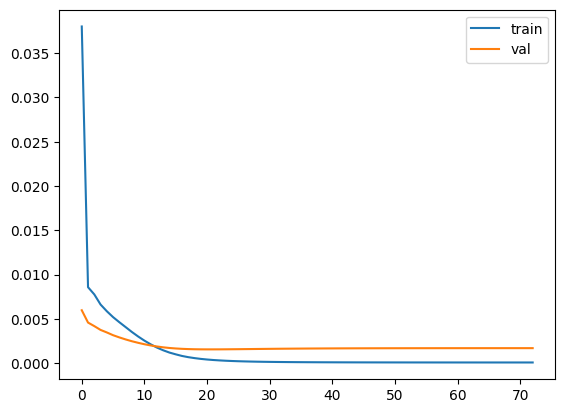

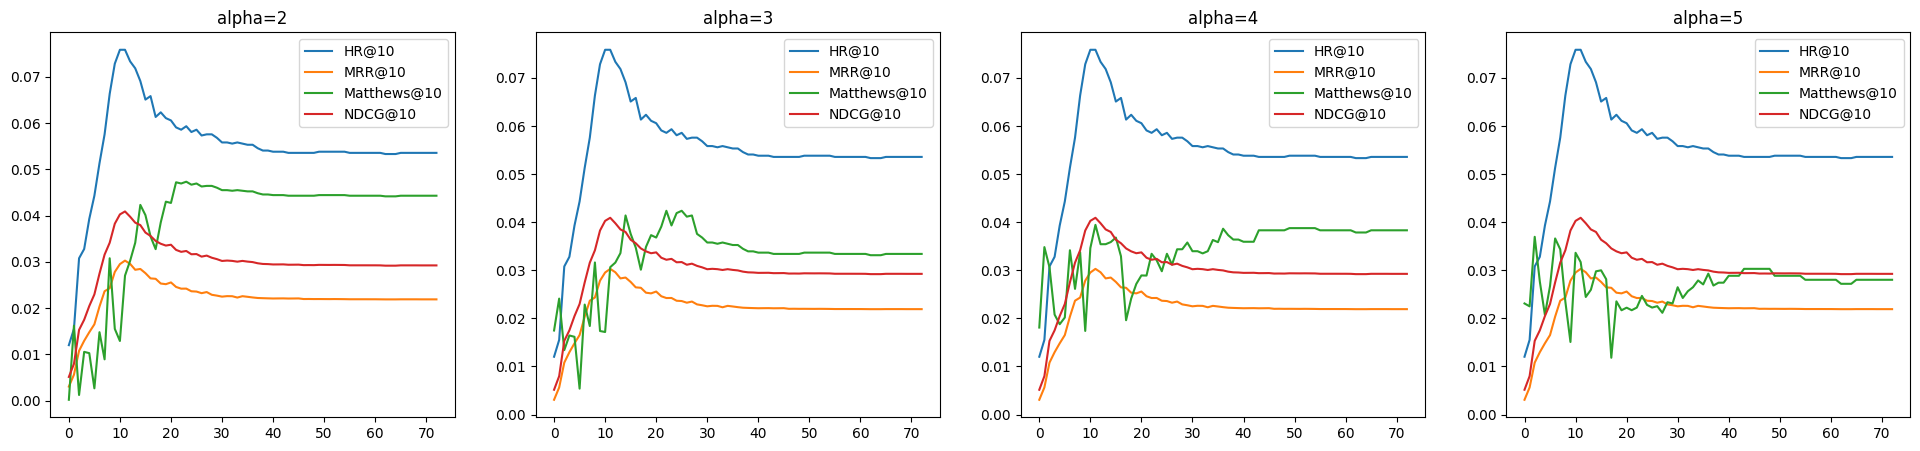

Test loss: 0.0015632685972377658
Train loss: 0.00027240141745988293


Hidden sizes: 1024
Current epoch 70
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.042709  0.024646    0.105391  0.029101  0.041613  0.001095     0.0239   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000745    0.028268    0.000833    0.024823

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.063698  0.027336     0.147991  0.035779   0.061873   0.001825   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.026504    0.000833      0.03472     0.001059     0.027104

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.09217  0.02927     0.204119  0.042926   0.088885   0.003285    0.028341   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000929     0.041504     0.001422     0.023047

Results for alpha=3


HR@5   MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.038146  0.0206    0.501817  0.024935    0.0334  0.004745   0.018233   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.002367    0.021981    0.002954   -0.017267

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.054937  0.022733     0.639612  0.030257   0.049462   0.005475   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10     0.02026    0.002473     0.027057     0.003199    -0.000898

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.076109  0.024102      0.76489  0.035483   0.069356   0.006753   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.021547    0.002555     0.031969     0.003514     0.009465

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.042709  0.024646    0.105391  0.029101   0.03632  0.006388   0.020813   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.003833    0.024645    0.004455    0.029669

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.063698  0.027336     0.147991  0.035779   0.054572   0.009126   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10     0.02316    0.004177      0.03046     0.005319     0.040701

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.09217  0.02927     0.204119  0.042926   0.077386   0.014784    0.024699   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.004572     0.036173     0.006752     0.036236

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.042709  0.024646    0.105391  0.029101  0.031028  0.011681   0.017674   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.006972    0.020972    0.008129     0.05248

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.063698  0.027336     0.147991  0.035779   0.044716   0.018982   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.019433    0.007903     0.025332     0.010446     0.051739

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.09217  0.02927     0.204119  0.042926    0.06388    0.02829    0.020733   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008537     0.030141     0.012785      0.05738

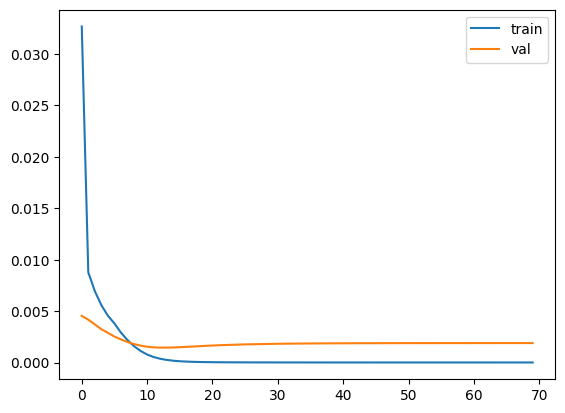

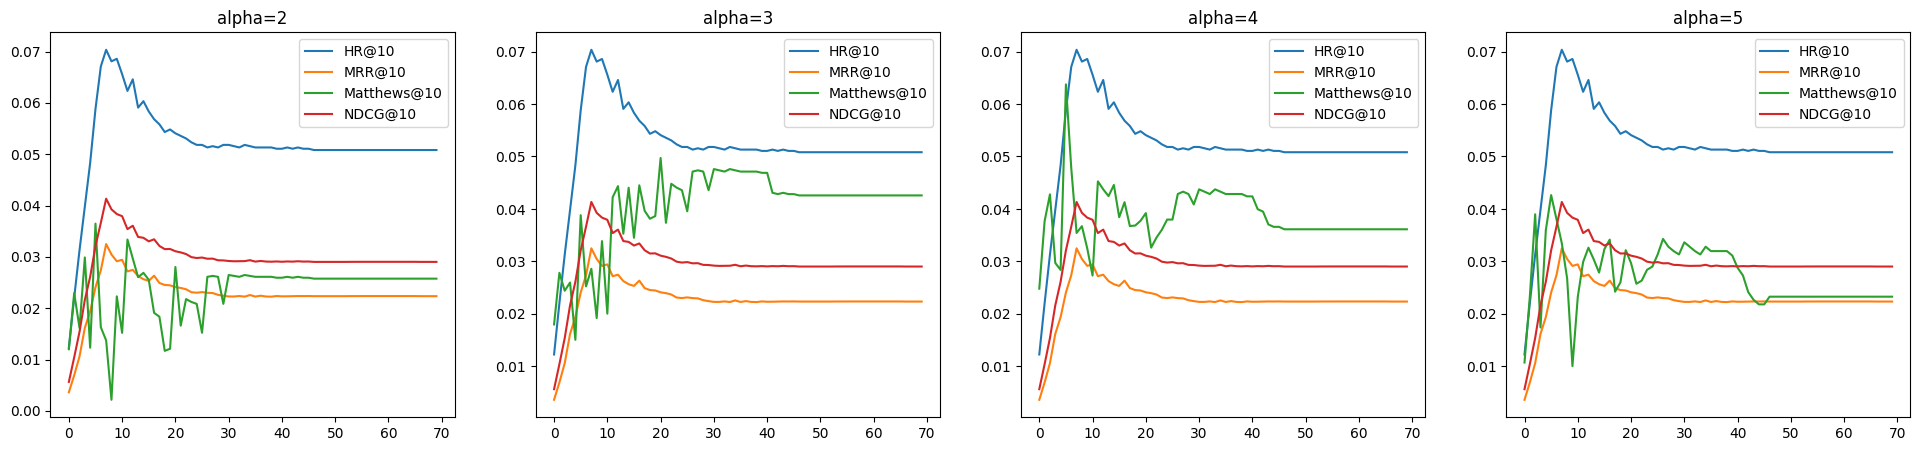

Test loss: 0.0016555858310312033
Train loss: 3.621298466281972e-05




In [39]:
# no noise
params = []
histories = []
early_stop = 50
n_epochs = 1000
batch_size = 16
num_batches = int(np.ceil(user_tensor_train.shape[0] / batch_size))

user_tensor_val = prepare_tensor(testset_valid, data_description).to_dense().to(device)
val_num_batches = int(np.ceil(user_tensor_val.shape[0] / batch_size))

user_tensor_test = prepare_tensor(testset, data_description).to_dense().to(device)
test_num_batches = int(np.ceil(user_tensor_test.shape[0] / batch_size))

for h in tqdm(grid):
    print('Hidden sizes:', h)
    
    bae = baseAE(data_description['n_items'], h).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(bae.parameters())
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    params.append(sum(p.numel() for p in bae.parameters() if p.requires_grad))
    
    # Training the AE
    history = []
    val_history = []

    hrs2 = []
    mrrs2 = []
    cs2 = []
    ndcgs2 = []

    hrs3 = []
    mrrs3 = []
    cs3 = []
    ndcgs3 = []

    hrs4 = []
    mrrs4 = []
    cs4 = []
    ndcgs4 = []
    
    hrs5 = []
    mrrs5 = []
    cs5 = []
    ndcgs5 = []

    prev_matt2 = [0]
    prev_matt3 = [0]
    prev_matt4 = [0]
    prev_matt5 = [0]
    
    for epoch in range(1, n_epochs+1):
#         print(epoch)
        train_loss = 0
        shuffle = np.random.choice(user_tensor_train.shape[0], size=user_tensor_train.shape[0], replace=False)
        user_tensor_train = user_tensor_train[shuffle]
        
        for batch in range(num_batches):
            optimizer.zero_grad()
            
            input_tensor = user_tensor_train[batch * batch_size: (batch+1) * batch_size].to(device)
            target = input_tensor.clone()

            output = bae(input_tensor)
            target.require_grad = False # we don't use it in training

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item()

        scheduler.step()
        history.append(train_loss / num_batches)

        test_loss = 0
        scores = torch.zeros((testset_valid.userid.nunique(), data_description['n_items']))
        
        with torch.no_grad():
            for batch in range(val_num_batches):
                input_tensor = user_tensor_val[batch * batch_size: (batch+1) * batch_size].to(device)
                target = input_tensor.clone()
            
                output = bae(input_tensor)
                target.require_grad = False

                test_loss += criterion(output, target)
                scores[batch * batch_size: (batch+1) * batch_size] = output.clone()
        
        scores = scores.detach().cpu().numpy()
        val_loss = test_loss / val_num_batches
        val_history.append(val_loss.item())
        
        downvote_seen_items(scores, testset_valid, data_description)
        
        prev_matt2 = predict_and_check(scores, holdout_valid, data_description, hrs2, mrrs2, cs2, ndcgs2, 2, prev_matt2, epoch)
        prev_matt3 = predict_and_check(scores, holdout_valid, data_description, hrs3, mrrs3, cs3, ndcgs3, 3, prev_matt3, epoch)
        prev_matt4 = predict_and_check(scores, holdout_valid, data_description, hrs4, mrrs4, cs4, ndcgs4, 4, prev_matt4, epoch)
        prev_matt5 = predict_and_check(scores, holdout_valid, data_description, hrs5, mrrs5, cs5, ndcgs5, 5, prev_matt5, epoch)

        # if prev_test_loss[-1] > val_loss:
        #     prev_test_loss = [val_loss]
        #     torch.save(ae.state_dict(), f'best_ae_{h1}_{h2}.pt')
        # else:
        #     prev_test_loss.append(val_loss)
        
        # stop = epoch if epoch < early_stop else epoch-early_stop
        if len(prev_matt2) >= early_stop and len(prev_matt3) >= early_stop and len(prev_matt4) >= early_stop and len(prev_matt5) >= early_stop:
            print(f'Current epoch {epoch}')
            break
            
    
    # Testing the AE
    check_test(bae, criterion, user_tensor_test, testset, holdout, data_description, test_num_batches, 2, batch_size=16, dcg=True)
    check_test(bae, criterion, user_tensor_test, testset, holdout, data_description, test_num_batches, 3, batch_size=16, dcg=True)
    check_test(bae, criterion, user_tensor_test, testset, holdout, data_description, test_num_batches, 4, batch_size=16, dcg=True)
    check_test(bae, criterion, user_tensor_test, testset, holdout, data_description, test_num_batches, 5, batch_size=16, dcg=True)
    
    # our
    plt.plot(history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.show()
    
    hrs = [hrs2, hrs3, hrs4, hrs5]
    mrrs = [mrrs2, mrrs3, mrrs4, mrrs5]
    cs = [cs2, cs3, cs4, cs5]
    ndcgs = [ndcgs2, ndcgs3, ndcgs4, ndcgs5]

    fig = plt.figure(figsize=(24,5))
    axes = fig.subplots(nrows=1, ncols=4)
    for i in range(4):
        axes[i].set_title(f'alpha={i+2}')
        axes[i].plot(hrs[i], label='HR@10')
        axes[i].plot(mrrs[i], label='MRR@10')
        axes[i].plot(cs[i], label='Matthews@10')
        axes[i].plot(ndcgs[i], label='NDCG@10')
        axes[i].legend()
        
    plt.show()
    
    print('Test loss:', val_history[-min(early_stop, epoch)])
    print('Train loss:', history[-min(early_stop, epoch)])
    
    print()
    print()

In [20]:
train_dataset = SimpleDataset(user_tensor_train, augment=True)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

  0%|          | 0/9 [00:00<?, ?it/s]

Hidden sizes: 4
Current epoch 56
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.005658  0.002181    0.001918  0.003038  0.005658       0.0   0.002181   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5        0.0    0.003038         0.0    0.017604

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.016244  0.003595     0.003432  0.006465   0.016244        0.0   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.003595         0.0     0.006465          0.0     0.029989

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.0261  0.004302     0.004946  0.008988    0.02537    0.00073    0.004252   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000051     0.008803     0.000185     0.017515

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010586  0.004274    0.001514  0.005864  0.009491  0.001095   0.003863   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000411    0.005282    0.000583   -0.001697

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.015331  0.004869     0.002423  0.007361   0.014054   0.001278   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.004438    0.000431     0.006724     0.000638     0.006374

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.029385  0.005852     0.004543  0.010926   0.027195    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.005361    0.000491     0.010062     0.000864     0.014024

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.005658  0.002181    0.001918  0.003038  0.004928   0.00073   0.001926   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000256    0.002666    0.000372    0.014424

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.016244  0.003595     0.003432  0.006465   0.014784    0.00146   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10     0.00324    0.000355     0.005855      0.00061     0.036999

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.0261  0.004302     0.004946  0.008988   0.023544   0.002555    0.003871   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000432       0.0081     0.000888     0.043894

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.005658  0.002181    0.001918  0.003038  0.004015  0.001643     0.0015   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000681     0.00212    0.000918    0.016147

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.016244  0.003595     0.003432  0.006465   0.013324    0.00292   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.002742    0.000853     0.005132     0.001333     0.056565

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.0261  0.004302     0.004946  0.008988   0.021719    0.00438    0.003347   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000956     0.007285     0.001704     0.076062

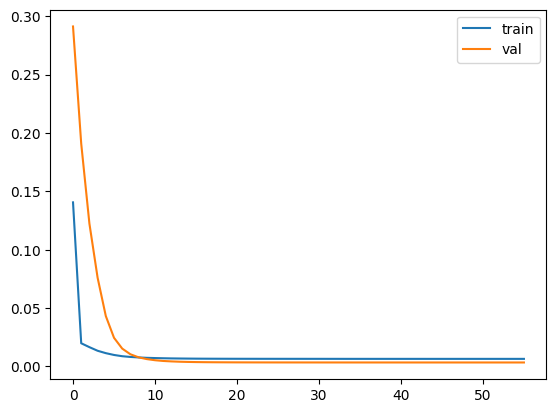

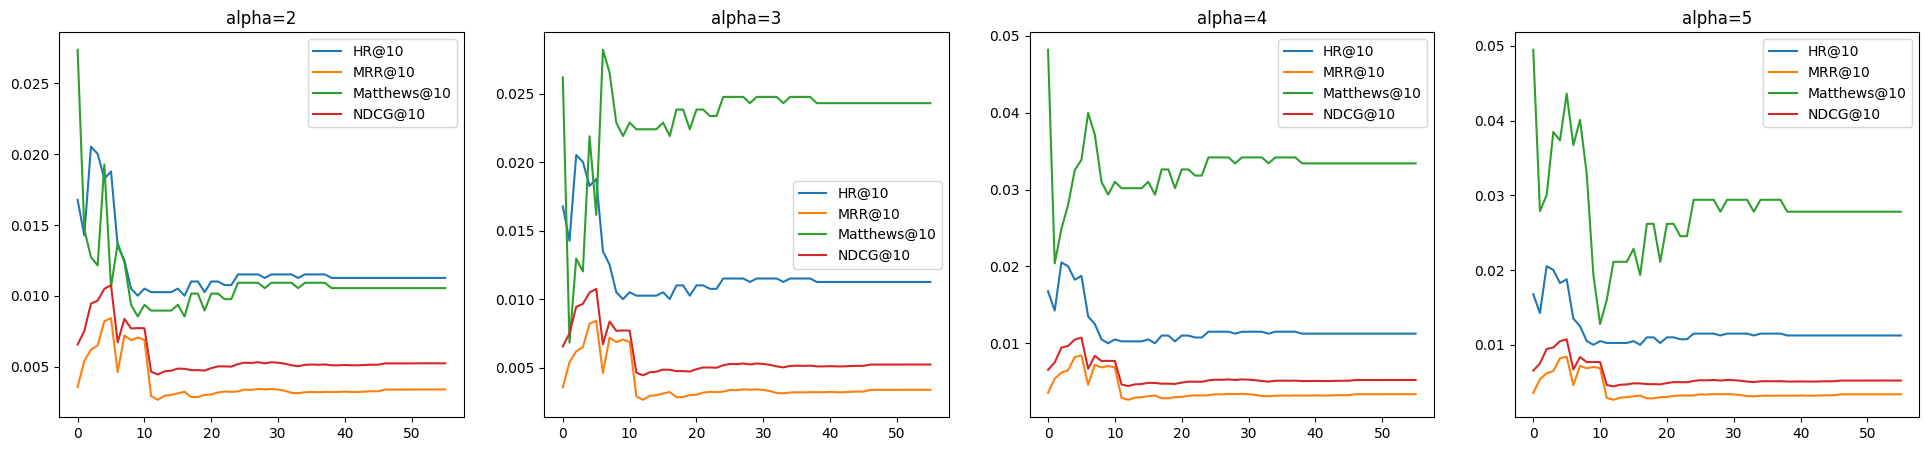

Test loss: 0.015280754305422306
Train loss: 0.008757737969904957


Hidden sizes: 8
Current epoch 64
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010038  0.005162    0.001211  0.006421  0.009491  0.000548   0.004797   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000365    0.006008    0.000413   -0.001317

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013324  0.005551     0.002322  0.007433   0.012594    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.005168    0.000383     0.006967     0.000466     -0.00165

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.025005  0.006324     0.004341  0.010341   0.024092   0.000913   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.005931    0.000393     0.009833     0.000509     0.010966

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009856  0.004977     0.00111  0.006239  0.008578  0.001278    0.00421   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000767    0.005343    0.000896     -0.0104

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.013324  0.005423     0.001716  0.007345   0.012046   0.001278   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.004657    0.000767     0.006449     0.000896      0.00104

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021172  0.005939     0.004038  0.009292   0.019347   0.001825   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.005136    0.000803     0.008259     0.001033     0.006094

Results for alpha=4


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010038  0.00355    0.000909  0.005171  0.008761  0.001278   0.003078   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000471    0.004497    0.000674    0.019693

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.012046  0.003792     0.002019  0.005795   0.010586    0.00146   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10      0.0033    0.000492     0.005066     0.000729     0.023248

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.021902  0.004455     0.003634  0.008259   0.018799   0.003103   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.003862    0.000592     0.007132     0.001127     0.023942

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010038  0.006774    0.001312  0.007613  0.008396  0.001643   0.005816   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000958    0.006479    0.001135    0.047652

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.012411  0.007064     0.003028  0.008353   0.010038   0.002373   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.006018    0.001045     0.006993      0.00136     0.046733

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.025735  0.007976     0.005047  0.011705   0.020077   0.005658   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.006691    0.001285       0.0095     0.002205     0.058217

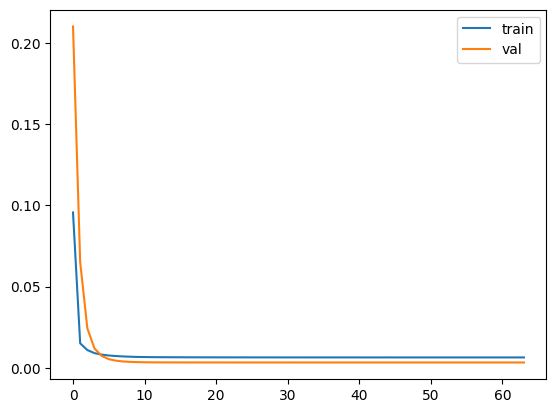

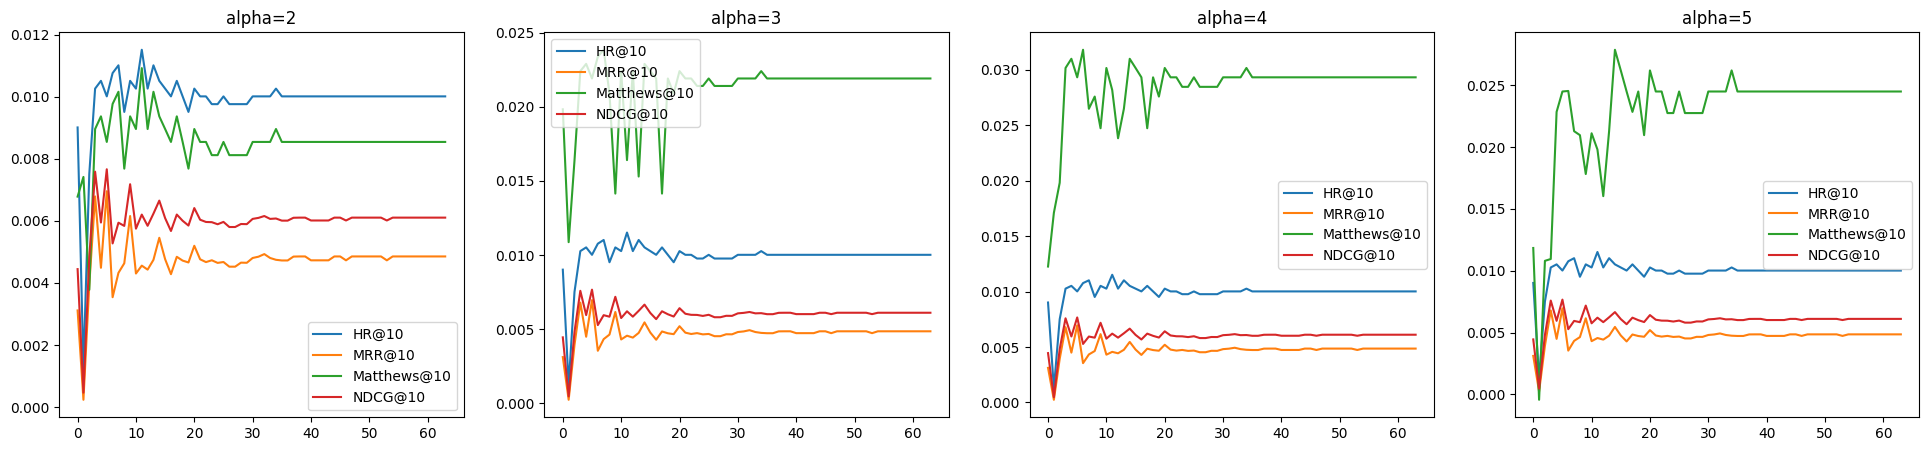

Test loss: 0.00336844171397388
Train loss: 0.006549897197439343


Hidden sizes: 16
Current epoch 122
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.014236  0.009518    0.004543  0.010664  0.013506   0.00073   0.009047   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000471    0.010129    0.000535    0.000201

HR@10   MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  MRR_pos@10  \
10  0.019894  0.01029     0.007167  0.01251   0.018982   0.000913    0.009798   

    MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000492     0.011921      0.00059     0.003721

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.032123  0.011049     0.009994  0.015489   0.030845   0.001278   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.010535    0.000514     0.014811     0.000678     0.009778

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.012046  0.009071    0.004139  0.009799  0.010768  0.001278   0.008174   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000897    0.008808    0.000991   -0.002779

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.019164  0.009995     0.005855  0.012074   0.017704    0.00146   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009067    0.000928     0.011018     0.001056     0.010489

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.029385  0.010612     0.008783  0.014541   0.027377   0.002008   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.009649    0.000963      0.01335     0.001191      0.01765

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.014236  0.009518    0.004543  0.010664  0.012411  0.001825   0.008469   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001049    0.009424     0.00124    0.023225

HR@10   MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  MRR_pos@10  \
10  0.019894  0.01029     0.007167  0.01251   0.017156   0.002738    0.009119   

    MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.001171     0.010976     0.001534     0.024222

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.032123  0.011049     0.009994  0.015489   0.028472    0.00365   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.009821    0.001228     0.013732     0.001757     0.041765

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010038  0.003516    0.001009  0.005143  0.008396  0.001643   0.002932   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000584    0.004294    0.000848    0.047652

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  \
10  0.012411  0.003823     0.002019   0.0059   0.010221    0.00219   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.003168    0.000656     0.004876     0.001024     0.050105

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.025005  0.004672      0.00424  0.009056   0.020624    0.00438   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.003861    0.000811     0.007473     0.001583     0.071999

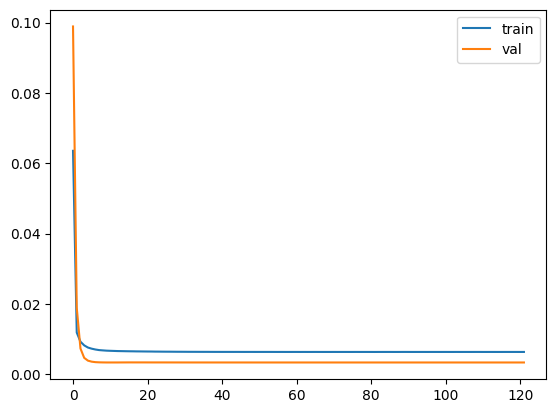

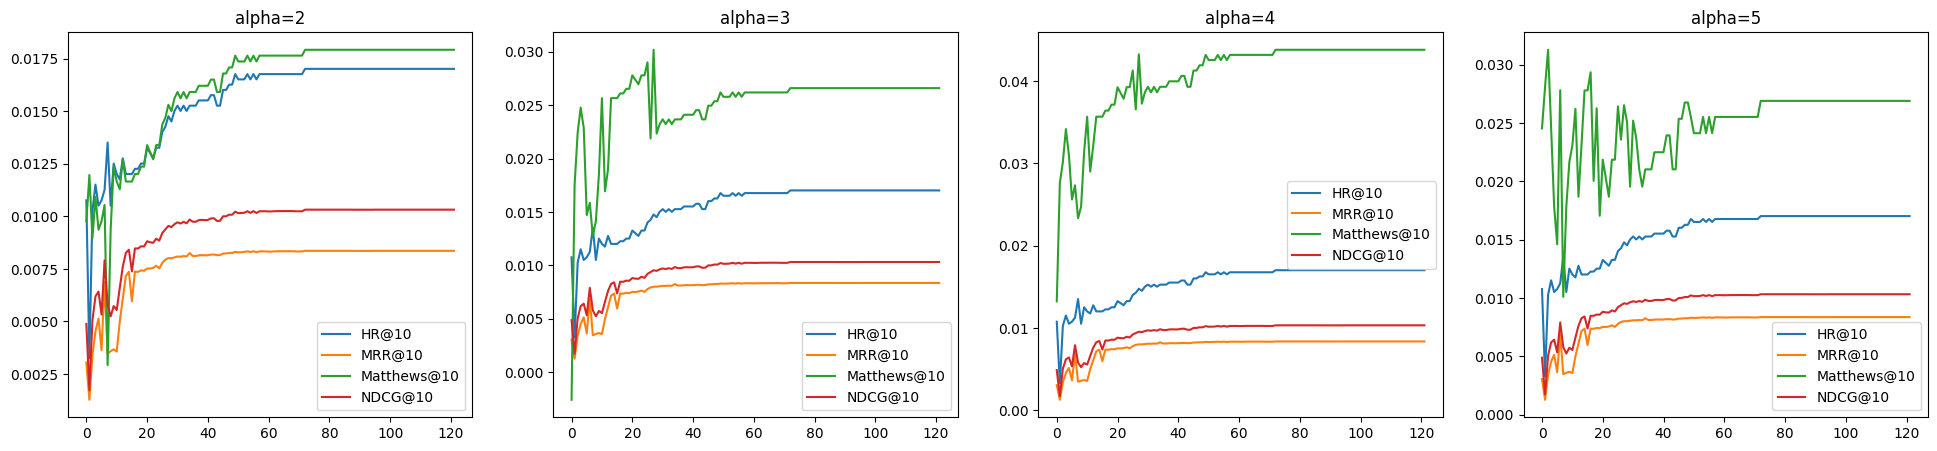

Test loss: 0.0033010009210556746
Train loss: 0.00629966362817428


Hidden sizes: 32
Current epoch 74
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.024822  0.011581     0.00747  0.014862  0.023909  0.000913   0.011118   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000462    0.014287    0.000575    0.010731

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.030297  0.012315     0.009792  0.016636   0.029385   0.000913   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.011853    0.000462     0.016062     0.000575     0.017196

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.043256  0.013215     0.015647  0.019913   0.041431   0.001825   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.012696    0.000519     0.019116     0.000797     0.009086

Results for alpha=3


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.012776  0.00637    0.003634  0.007993  0.011316   0.00146   0.005792   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000578    0.007192      0.0008   -0.006003

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.019164  0.007193     0.005754  0.010029   0.017704    0.00146   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.006615    0.000578     0.009229       0.0008     0.010489

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.029385  0.007849     0.008278  0.012545   0.027377   0.002008   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.007233    0.000615     0.011607     0.000938      0.01765

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.019712  0.009871    0.005855  0.012295  0.017886  0.001825   0.008764   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001107    0.011011    0.001284    0.039882

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.029567  0.011146     0.008278  0.015442   0.026647    0.00292   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009889    0.001256     0.013801     0.001642      0.04643

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.039423  0.01179     0.012821  0.017884   0.034495   0.004928   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.010414    0.001376      0.01576     0.002124     0.040756

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010403  0.008809    0.002221  0.009206  0.008396  0.002008   0.007419   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00139    0.007664    0.001542    0.042364

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.016426  0.009568      0.00424  0.011109   0.012594   0.003833   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.007928     0.00164      0.00897     0.002139     0.042729

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.030297  0.010603     0.006562  0.014706   0.024822   0.005475   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.008837    0.001766     0.012137     0.002569     0.077467

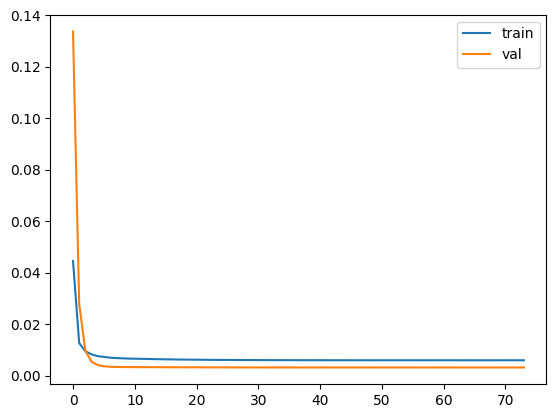

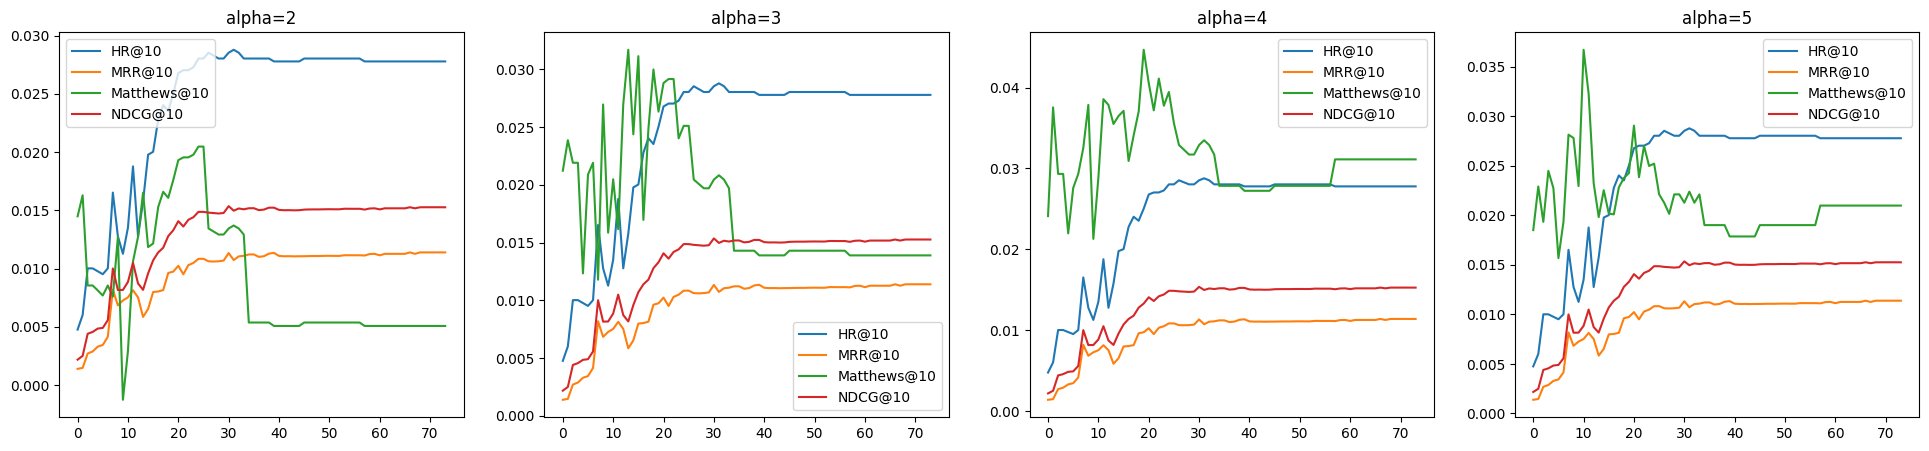

Test loss: 0.00321189989335835
Train loss: 0.0061146538689922664


Hidden sizes: 64
Current epoch 76
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.019894  0.009238    0.007369  0.011917  0.018799  0.001095   0.008584   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000654    0.011152    0.000765   -0.002185

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  MRR_pos@10  \
10  0.03121  0.010683     0.010196  0.01551   0.030115   0.001095    0.010029   

    MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.000654     0.014745     0.000765     0.013433

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.041613  0.011395     0.016959  0.018129   0.039971   0.001643   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.010705     0.00069     0.017227     0.000902     0.011466

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.014419  0.006914    0.005047  0.008806  0.012959   0.00146   0.006324   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00059    0.007998    0.000808   -0.001099

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.018799  0.007516     0.007167  0.010239   0.017156   0.001643   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.006895    0.000621     0.009366     0.000873     0.005192

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.02902  0.008172     0.010902  0.012758   0.026282   0.002738   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.007478    0.000694      0.01161     0.001147     0.002447

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.025552  0.013999    0.014839  0.016845  0.023179  0.002373   0.012274   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001725    0.014962    0.001883    0.045437

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.041431  0.016058     0.021199  0.021921   0.036686   0.004745   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.014022    0.002035     0.019277     0.002644     0.047199

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.056762  0.017108     0.030789  0.025779   0.050192   0.006571   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.014938     0.00217     0.022664     0.003116     0.054954

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.025552  0.013999    0.014839  0.016845  0.020989  0.004563   0.010893   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.003106    0.013381    0.003465    0.071681

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.041431  0.016058     0.021199  0.021921   0.032853   0.008578   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.012434    0.003624     0.017175     0.004745     0.079917

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.056762  0.017108     0.030789  0.025779   0.043986   0.012776   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.013205    0.003904     0.019988     0.005792     0.085251

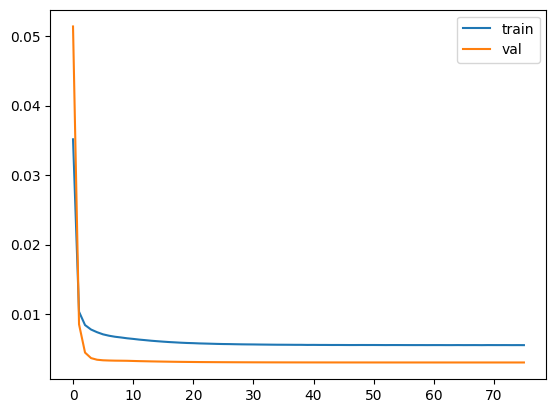

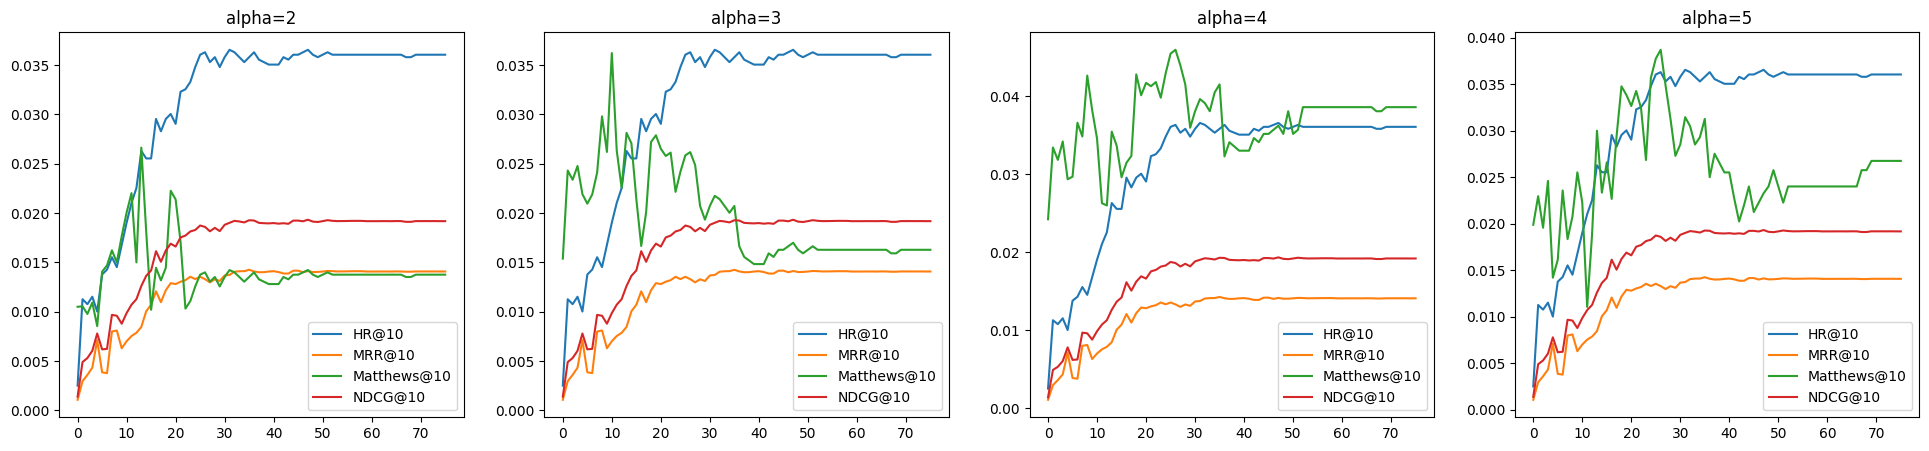

Test loss: 0.0030623776838183403
Train loss: 0.005670420358122699


Hidden sizes: 128
Current epoch 93
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.03486  0.020472    0.032203  0.024017  0.033583  0.001278   0.019623   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000849    0.023067     0.00095    0.012883

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.052017  0.022742     0.044619  0.029545   0.050557    0.00146   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.021875    0.000867     0.028542     0.001003     0.024958

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.074649  0.024307     0.066021  0.035257   0.072641   0.002008   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20      0.0234    0.000907     0.034114     0.001143     0.031771

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.035043  0.020268    0.031799  0.023914  0.033218  0.001825   0.019085   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001183    0.022575    0.001339    0.029713

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  \
10  0.052382  0.022543     0.044619  0.02948   0.049097   0.003285   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.021152     0.00139     0.027657     0.001823      0.02827

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.074466  0.024079      0.06592  0.035066   0.069721   0.004745   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.022586    0.001493     0.032872     0.002193     0.033148

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.035043  0.020268    0.031799  0.023914  0.031028  0.004015   0.017963   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.002306    0.021188    0.002725    0.043242

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  \
10  0.052382  0.022543     0.044619  0.02948   0.045811   0.006571   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.019898    0.002645     0.025931     0.003549     0.047046

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.074466  0.024079      0.06592  0.035066   0.063698   0.010768   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.021144    0.002935     0.030457     0.004609     0.043323

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.035043  0.020268    0.031799  0.023914  0.027195  0.007848   0.015754   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.004514    0.018581    0.005332    0.066663

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  \
10  0.052382  0.022543     0.044619  0.02948   0.039058   0.013324   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.017307    0.005236     0.022386     0.007094     0.067626

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.074466  0.024079      0.06592  0.035066   0.054024   0.020442   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.018374    0.005705     0.026205     0.008861     0.069893

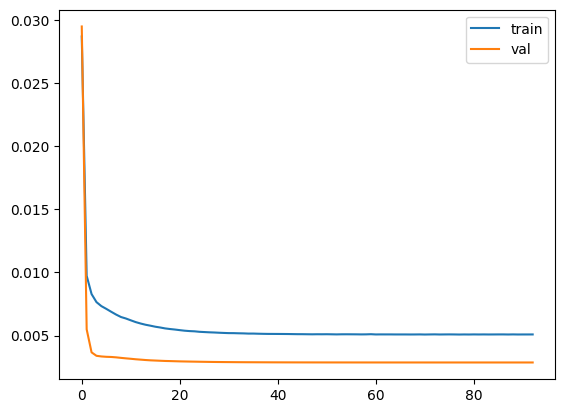

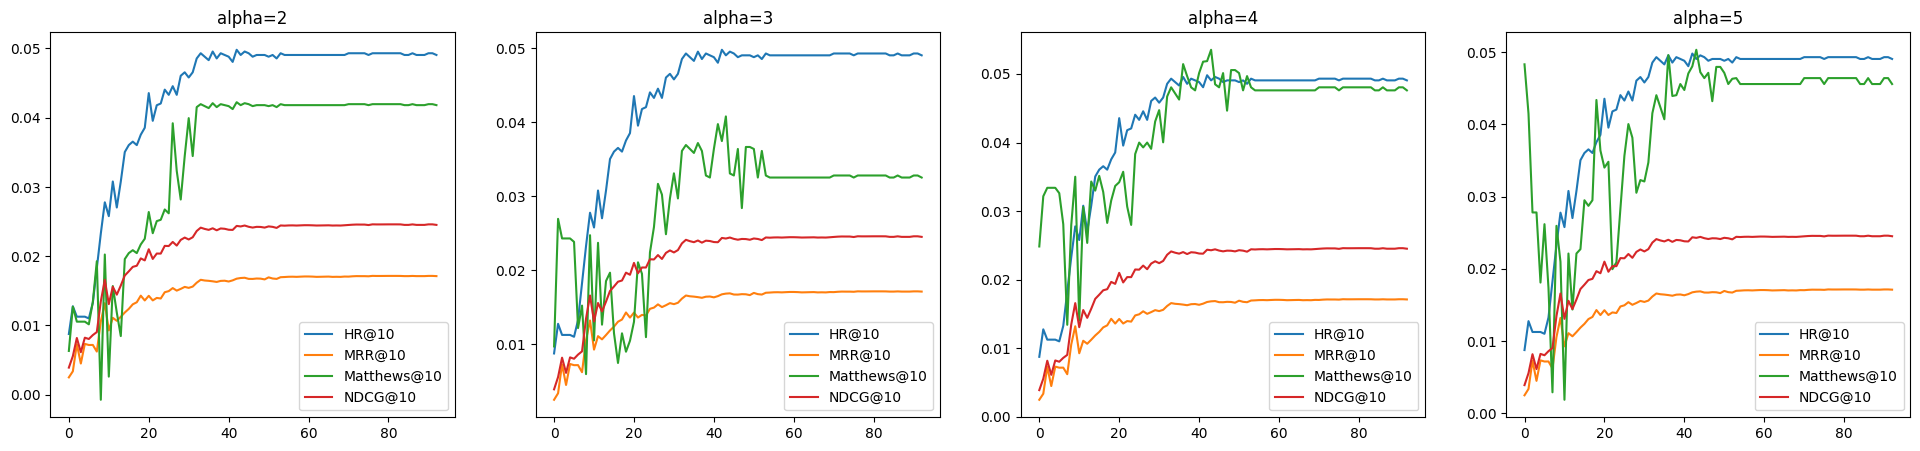

Test loss: 0.002874757396057248
Train loss: 0.005116093989783041


Hidden sizes: 256
Current epoch 73
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.027377  0.016712    0.027761  0.019335  0.026647   0.00073   0.016104   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000608    0.018696    0.000639     0.01894

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.041613  0.018572      0.03937  0.023899   0.040518   0.001095   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.017925    0.000647     0.023153     0.000747     0.023854

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.062785  0.020027     0.057844  0.029234   0.061143   0.001643   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.019333    0.000694     0.028337     0.000896     0.029808

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.024092  0.014781    0.018676  0.017078  0.022449  0.001643   0.013667   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001113    0.015839     0.00124    0.016012

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.038146  0.016647     0.027458  0.021615   0.035773   0.002373   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.015432    0.001215     0.020134     0.001481     0.024291

HR@20    MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  \
20  0.056945  0.017898     0.040985   0.0263   0.053477   0.003468   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.016619    0.001279     0.024558     0.001742     0.031048

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.03559  0.021223    0.037957  0.024782  0.031393  0.004198   0.019042   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.002181      0.0221    0.002682    0.041994

HR@10  MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  MRR_pos@10  \
10  0.049827  0.0231     0.053301  0.029363   0.042891   0.006936    0.020558   

    MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.002542       0.0258     0.003563     0.038038

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.072824  0.024659     0.077024  0.035133   0.061873   0.010951   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.021824    0.002836     0.030536     0.004598      0.03881

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.039788  0.025713    0.042399  0.029203  0.028107  0.011681   0.018367   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.007346    0.020776    0.008426    0.042218

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.05731  0.027944     0.060166  0.034759   0.040701   0.016609   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.019968    0.007977     0.024767     0.009992     0.053038

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.079212  0.029438     0.088229  0.040264    0.05658   0.022632   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.021057    0.008381     0.028767     0.011497     0.065548

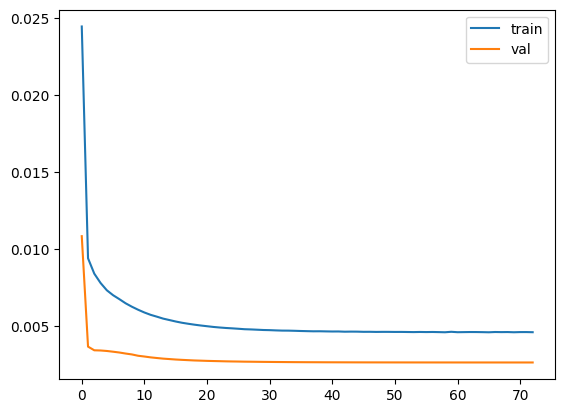

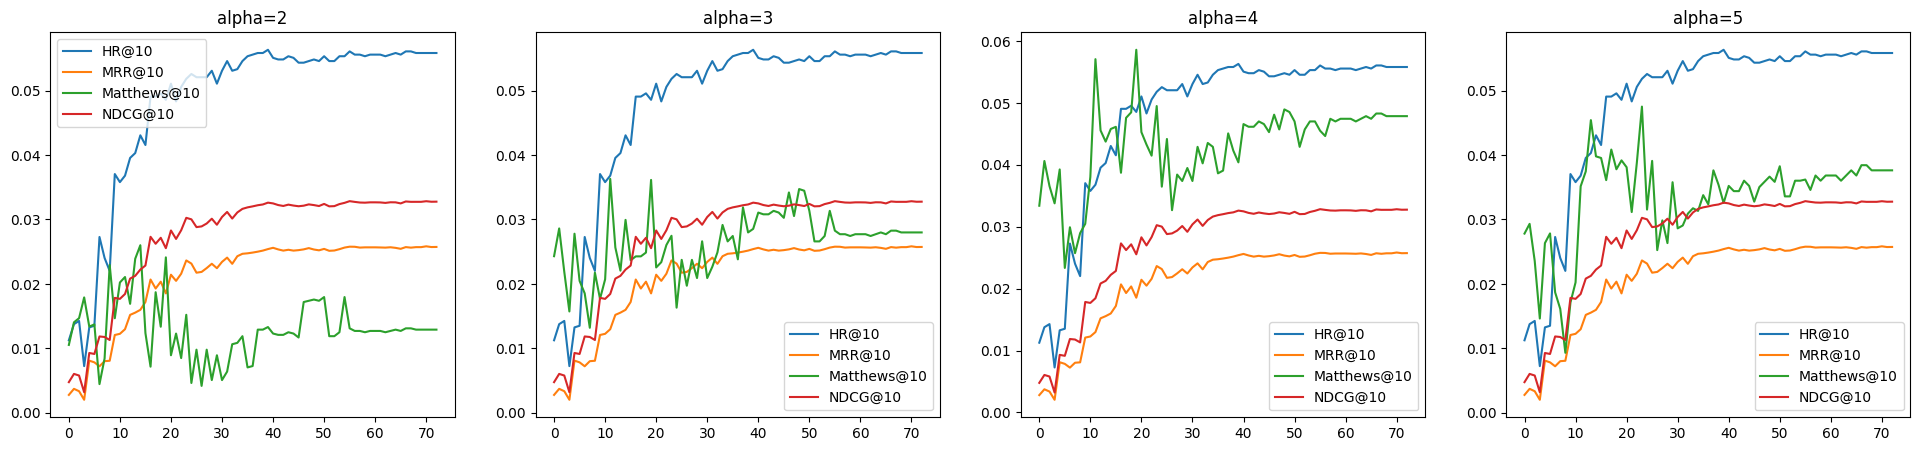

Test loss: 0.002732566324993968
Train loss: 0.0048971915875594355


Hidden sizes: 512
Current epoch 63
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.023909  0.014251    0.025843  0.016637  0.023179   0.00073   0.013667   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000584    0.016018    0.000618    0.014933

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.037963  0.016157     0.037957  0.021212   0.036868   0.001095   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.015516    0.000641     0.020468     0.000744     0.020469

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.056945  0.017429     0.056733  0.025955    0.05512   0.001825   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.016741    0.000689      0.02503     0.000925     0.021762

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.023179  0.013771    0.007672  0.016091  0.021537  0.001643   0.012554   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001217    0.014766    0.001325    0.014311

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.033583  0.015131     0.011508  0.019428   0.031393    0.00219   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.013843    0.001288     0.017927     0.001501     0.020851

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.049462  0.016188     0.018776  0.023387   0.046906   0.002555   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.014876    0.001312     0.021795     0.001592     0.035891

Results for alpha=4


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.033583  0.01962    0.035029  0.023094   0.02902  0.004563   0.016971   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5    0.00265    0.019977    0.003117    0.032496

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.050009  0.021695     0.048758  0.028288   0.042891   0.007118   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.018729    0.002966     0.024369     0.003919     0.036331

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.070998  0.023151     0.071169  0.033594   0.060047   0.010951   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.019933    0.003218     0.028723     0.004871     0.035643

Results for alpha=5


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.033583  0.01962    0.035029  0.023094  0.024822  0.008761   0.014604   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.005016    0.017155    0.005939    0.051134

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.050009  0.021695     0.048758  0.028288   0.036868   0.013141   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.016151    0.005543     0.020989     0.007299     0.062043

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.070998  0.023151     0.071169  0.033594   0.050739   0.020259   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.017117    0.006034     0.024501     0.009093      0.06199

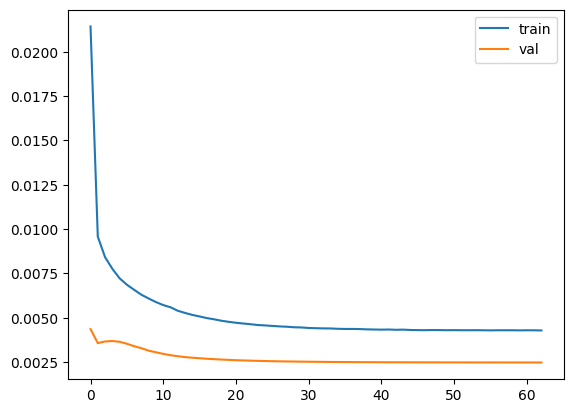

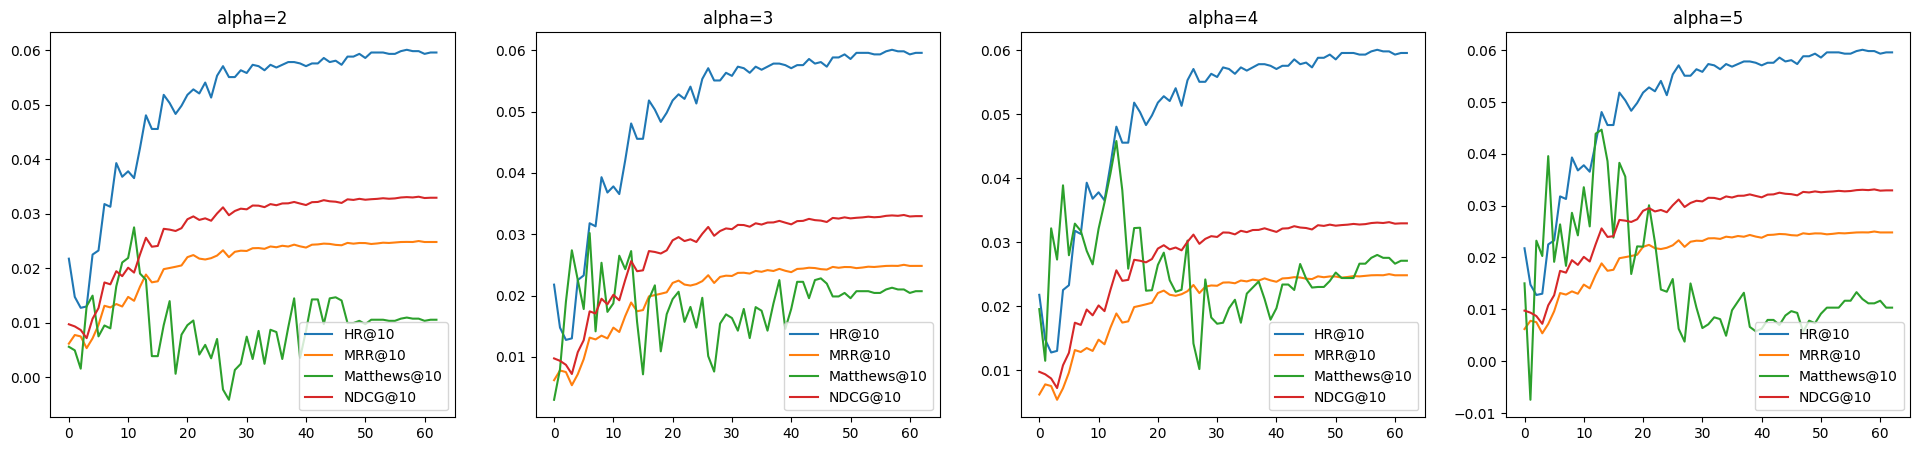

Test loss: 0.0027758791111409664
Train loss: 0.005268285139254493


Hidden sizes: 1024
Current epoch 79
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.048001  0.027435    0.097315  0.032505  0.046541   0.00146   0.026741   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000694    0.031627    0.000878    0.021543

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.068261  0.030043     0.132243  0.038959    0.06607    0.00219   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.029253     0.00079     0.037846     0.001113     0.023929

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.09655  0.031938     0.179992  0.046026   0.093813   0.002738   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.031109    0.000829     0.044773     0.001253      0.03441

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.048001  0.027435    0.097315  0.032505  0.044169  0.003833   0.025668   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001767     0.03024    0.002265    0.014095

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.068261  0.030043     0.132243  0.038959    0.06315    0.00511   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10     0.02811    0.001932     0.036286     0.002673     0.021514

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.09655  0.031938     0.179992  0.046026    0.08998   0.006571   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.029899    0.002039     0.042976      0.00305     0.033457

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.03413  0.020463    0.028266  0.023833  0.029385  0.004745   0.018194   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.002269    0.020966    0.002867    0.031298

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.049644  0.022541     0.038865  0.028856   0.042891   0.006753   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.019978    0.002563     0.025313     0.003543     0.039752

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.067348  0.023764     0.056632  0.033322   0.058405   0.008943   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.021063    0.002701     0.029243     0.004078     0.048888

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.029385  0.016767    0.022814  0.019857  0.023544   0.00584   0.013722   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.003045    0.016129    0.003729    0.069836

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.045811  0.018953     0.033818  0.025163   0.035043   0.010768   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.015261    0.003692     0.019852     0.005311     0.071673

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.06242  0.020108      0.04785  0.029365   0.048001   0.014419   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.016173    0.003935     0.023144      0.00622     0.086546

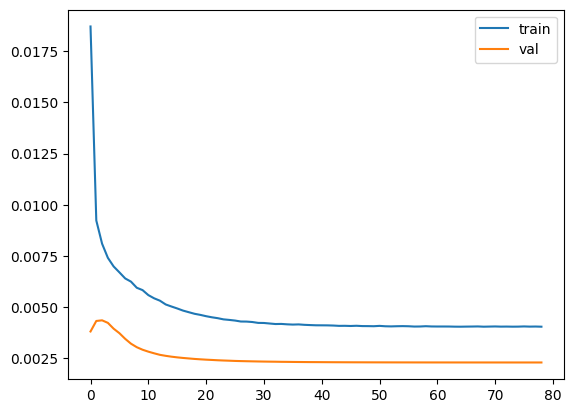

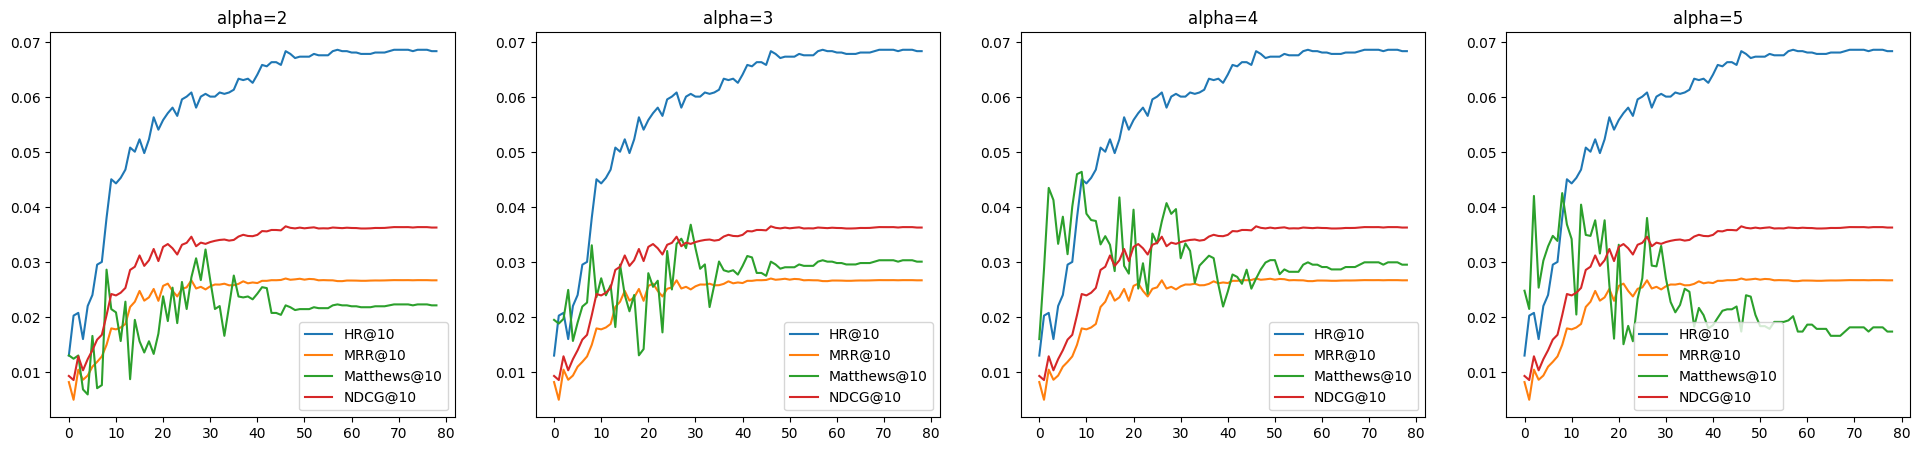

Test loss: 0.0023493512999266386
Train loss: 0.004232357679622956




In [42]:
# noise
params = []
histories = []
early_stop = 50
n_epochs = 1000
batch_size = 16
num_batches = int(np.ceil(user_tensor_train.shape[0] / batch_size))

user_tensor_val = prepare_tensor(testset_valid, data_description).to_dense().to(device)
val_num_batches = int(np.ceil(user_tensor_val.shape[0] / batch_size))

user_tensor_test = prepare_tensor(testset, data_description).to_dense().to(device)
test_num_batches = int(np.ceil(user_tensor_test.shape[0] / batch_size))

for h in tqdm(grid):
    print('Hidden sizes:', h)
    
    bae = baseAE(data_description['n_items'], h).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(bae.parameters())
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    params.append(sum(p.numel() for p in bae.parameters() if p.requires_grad))
    
    # Training the AE
    history = []
    val_history = []

    hrs2 = []
    mrrs2 = []
    cs2 = []
    ndcgs2 = []

    hrs3 = []
    mrrs3 = []
    cs3 = []
    ndcgs3 = []

    hrs4 = []
    mrrs4 = []
    cs4 = []
    ndcgs4 = []
    
    hrs5 = []
    mrrs5 = []
    cs5 = []
    ndcgs5 = []

    prev_matt2 = [0]
    prev_matt3 = [0]
    prev_matt4 = [0]
    prev_matt5 = [0]
    
    for epoch in range(1, n_epochs+1):
#         print(epoch)
        train_loss = 0
        
        for batch in train_dataloader:
            optimizer.zero_grad()
            
            input_tensor, target = batch
            input_tensor, target = input_tensor.to_dense().to(device), target.to_dense().to(device)

            output = bae(input_tensor)
            target.require_grad = False # we don't use it in training

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item()

        scheduler.step()
        history.append(train_loss / num_batches)

        test_loss = 0
        scores = torch.zeros((testset_valid.userid.nunique(), data_description['n_items']))
        
        with torch.no_grad():
            for batch in range(val_num_batches):
                input_tensor = user_tensor_val[batch * batch_size: (batch+1) * batch_size].to(device)
                target = input_tensor.clone()
            
                output = bae(input_tensor)
                target.require_grad = False

                test_loss += criterion(output, target)
                scores[batch * batch_size: (batch+1) * batch_size] = output.clone()
        
        scores = scores.detach().cpu().numpy()
        val_loss = test_loss / val_num_batches
        val_history.append(val_loss.item())
        
        downvote_seen_items(scores, testset_valid, data_description)
        
        prev_matt2 = predict_and_check(scores, holdout_valid, data_description, hrs2, mrrs2, cs2, ndcgs2, 2, prev_matt2, epoch)
        prev_matt3 = predict_and_check(scores, holdout_valid, data_description, hrs3, mrrs3, cs3, ndcgs3, 3, prev_matt3, epoch)
        prev_matt4 = predict_and_check(scores, holdout_valid, data_description, hrs4, mrrs4, cs4, ndcgs4, 4, prev_matt4, epoch)
        prev_matt5 = predict_and_check(scores, holdout_valid, data_description, hrs5, mrrs5, cs5, ndcgs5, 5, prev_matt5, epoch)

        # if prev_test_loss[-1] > val_loss:
        #     prev_test_loss = [val_loss]
        #     torch.save(ae.state_dict(), f'best_ae_{h1}_{h2}.pt')
        # else:
        #     prev_test_loss.append(val_loss)
        
        # stop = epoch if epoch < early_stop else epoch-early_stop
        if len(prev_matt2) >= early_stop and len(prev_matt3) >= early_stop and len(prev_matt4) >= early_stop and len(prev_matt5) >= early_stop:
            print(f'Current epoch {epoch}')
            break
            
        epoch += 1
    
    # Testing the AE
    check_test(bae, criterion, user_tensor_test, testset, holdout, data_description, test_num_batches, 2, batch_size=16, dcg=True)
    check_test(bae, criterion, user_tensor_test, testset, holdout, data_description, test_num_batches, 3, batch_size=16, dcg=True)
    check_test(bae, criterion, user_tensor_test, testset, holdout, data_description, test_num_batches, 4, batch_size=16, dcg=True)
    check_test(bae, criterion, user_tensor_test, testset, holdout, data_description, test_num_batches, 5, batch_size=16, dcg=True)
    
    # our
    plt.plot(history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.show()
    
    hrs = [hrs2, hrs3, hrs4, hrs5]
    mrrs = [mrrs2, mrrs3, mrrs4, mrrs5]
    cs = [cs2, cs3, cs4, cs5]
    ndcgs = [ndcgs2, ndcgs3, ndcgs4, ndcgs5]

    fig = plt.figure(figsize=(24,5))
    axes = fig.subplots(nrows=1, ncols=4)
    for i in range(4):
        axes[i].set_title(f'alpha={i+2}')
        axes[i].plot(hrs[i], label='HR@10')
        axes[i].plot(mrrs[i], label='MRR@10')
        axes[i].plot(cs[i], label='Matthews@10')
        axes[i].plot(ndcgs[i], label='NDCG@10')
        axes[i].legend()
        
    plt.show()
    
    print('Test loss:', val_history[-min(early_stop, epoch)])
    print('Train loss:', history[-min(early_stop, epoch)])
    
    print()
    print()

In [21]:
grid = 2**np.arange(11, 15)

  0%|          | 0/4 [00:00<?, ?it/s]

Hidden sizes: 2048
Current epoch 64
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.025552  0.014626    0.032909  0.017321  0.024822   0.00073   0.014108   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000517    0.016749    0.000571    0.016887

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.043621  0.016959     0.045932  0.023087   0.041978   0.001643   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.016313    0.000646     0.022213     0.000874     0.013504

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.06534  0.01845     0.063295  0.028558   0.062968   0.002373    0.017749   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.000702     0.027493     0.001065     0.018325

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.03486  0.020901     0.05744  0.024376  0.033035  0.001825   0.019849   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001053    0.023136     0.00124    0.029459

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.050192  0.022909     0.081567  0.029296   0.046724   0.003468   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10     0.02165    0.001259     0.027538     0.001758     0.022726

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.072276  0.024437       0.1064  0.034873   0.066801   0.005475   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.023055    0.001382     0.032628     0.002245     0.021351

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.03486  0.020901     0.05744  0.024376  0.031028  0.003833   0.018556   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.002345    0.021666     0.00271    0.045302

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.050192  0.022909     0.081567  0.029296   0.043804   0.006388   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.020246    0.002664     0.025783     0.003513     0.044956

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.072276  0.024437       0.1064  0.034873   0.062055   0.010221   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.021526    0.002911     0.030414     0.004459     0.044833

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.035043  0.020341    0.068948  0.023951   0.02537  0.009673    0.01482   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.005521     0.01742    0.006531    0.046359

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.052747  0.022712     0.093378  0.029686   0.037963   0.014784   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.016523    0.006189     0.021515     0.008171     0.055361

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.076474  0.024321     0.126287  0.035638   0.053659   0.022814   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.017587    0.006734     0.025453     0.010185     0.056884

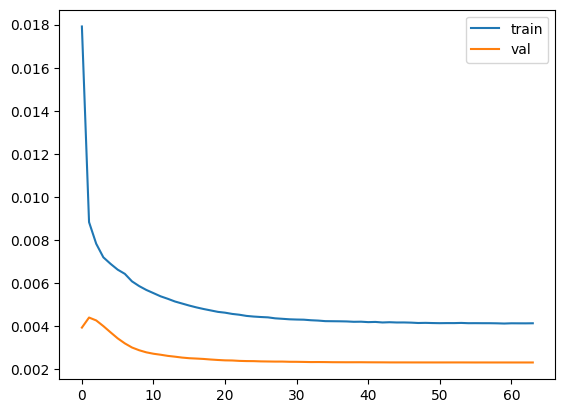

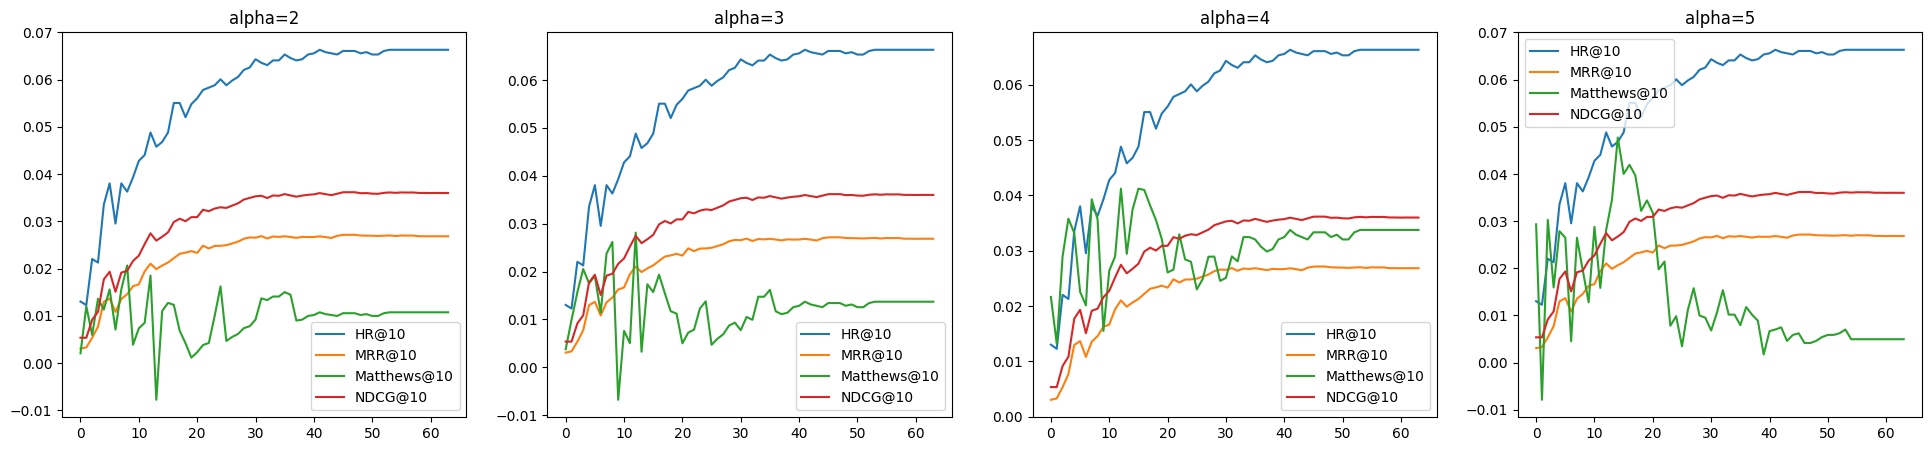

Test loss: 0.002552386373281479
Train loss: 0.005060600657762908


Hidden sizes: 4096
Current epoch 66
Results for alpha=2


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.023544  0.012594      0.0213  0.015282  0.022814   0.00073   0.012122   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000471    0.014747    0.000535    0.014484

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.033583  0.013886     0.029275  0.018481   0.032853    0.00073   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.013415    0.000471     0.017946     0.000535     0.025194

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.051287  0.015093      0.04149  0.022931   0.050192   0.001095   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.014598    0.000494     0.022307     0.000624      0.03183

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.032853  0.019785    0.112457  0.023043  0.031393   0.00146   0.018629   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001156    0.021809    0.001234     0.03346

HR@10    MRR@10  Coverage@10  NCDG@10  HR_pos@10  HR_neg@10  \
10  0.050557  0.022089      0.14577  0.02871   0.048184   0.002373   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.020813    0.001276     0.027183     0.001527     0.039968

HR@20   MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  MRR_pos@20  \
20  0.074649  0.02375     0.189481  0.03479   0.070451   0.004198    0.022339   

    MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.001411     0.032791     0.001999      0.04033

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.023544  0.012594      0.0213  0.015282  0.020442  0.003103   0.010908   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001685    0.013246    0.002037    0.028637

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.033583  0.013886     0.029275  0.018481   0.029932    0.00365   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.012144    0.001742     0.016284     0.002197     0.045012

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.051287  0.015093      0.04149  0.022931   0.045811   0.005475   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.013236    0.001857     0.020287     0.002644     0.057252

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.009126  0.002792    0.001918  0.004314  0.007483  0.001643   0.002327   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000465    0.003566    0.000749    0.042201

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.023544  0.004735     0.003634  0.008995   0.019894    0.00365   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.004001    0.000734     0.007597     0.001398     0.076212

HR@20    MRR@20  Coverage@20  NCDG@20  HR_pos@20  HR_neg@20  \
20  0.038876  0.005678     0.005855  0.01272   0.031028   0.007848   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.004699     0.00098     0.010318     0.002402     0.079438

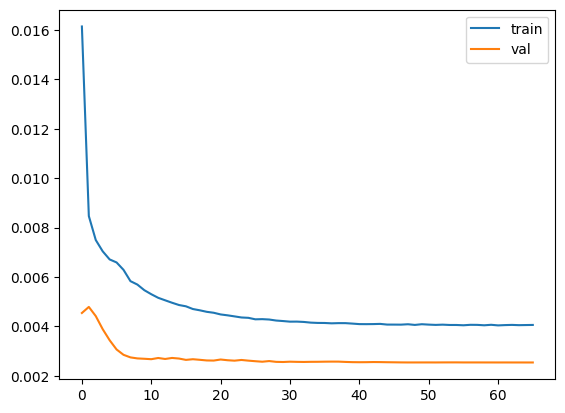

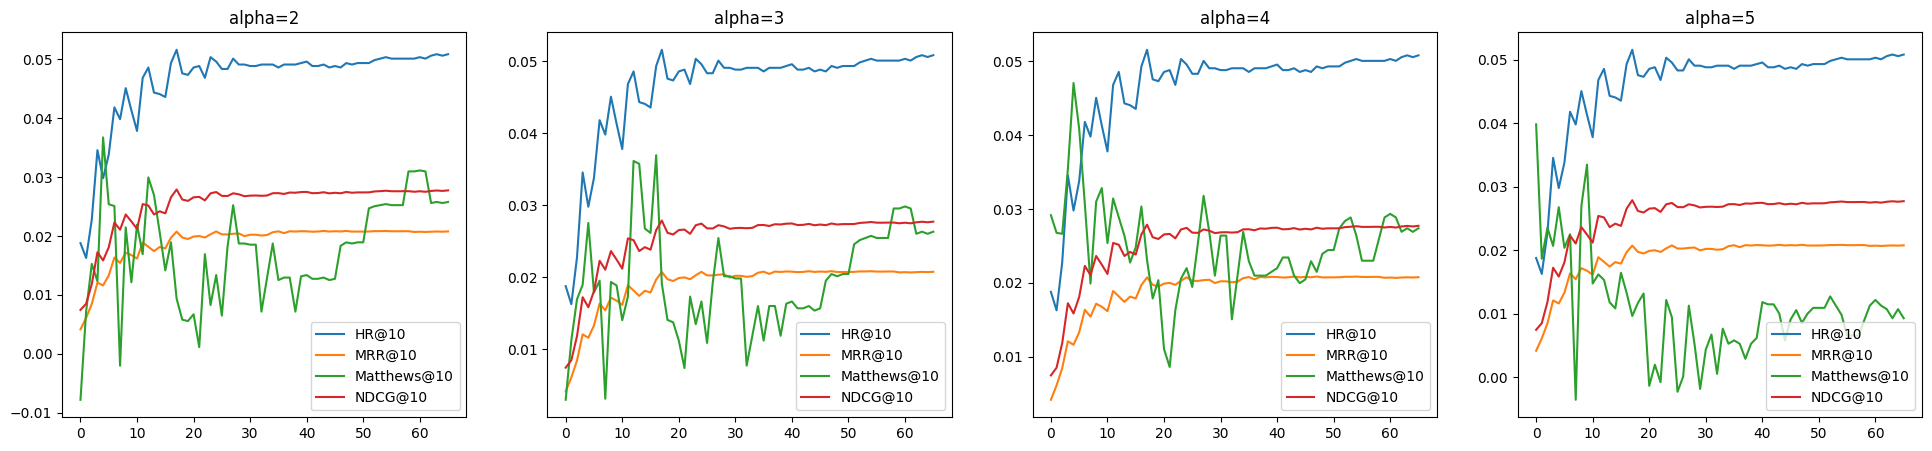

Test loss: 0.0026704270858317614
Train loss: 0.004703170574357323


Hidden sizes: 8192


OutOfMemoryError: CUDA out of memory. Tried to allocate 310.00 MiB (GPU 0; 4.00 GiB total capacity; 3.28 GiB already allocated; 0 bytes free; 3.41 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [22]:
# noise
params = []
histories = []
early_stop = 50
n_epochs = 1000
batch_size = 16
num_batches = int(np.ceil(user_tensor_train.shape[0] / batch_size))

user_tensor_val = prepare_tensor(testset_valid, data_description).to_dense().to(device)
val_num_batches = int(np.ceil(user_tensor_val.shape[0] / batch_size))

user_tensor_test = prepare_tensor(testset, data_description).to_dense().to(device)
test_num_batches = int(np.ceil(user_tensor_test.shape[0] / batch_size))

for h in tqdm(grid):
    print('Hidden sizes:', h)
    
    bae = baseAE(data_description['n_items'], h).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(bae.parameters())
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    params.append(sum(p.numel() for p in bae.parameters() if p.requires_grad))
    
    # Training the AE
    history = []
    val_history = []

    hrs2 = []
    mrrs2 = []
    cs2 = []
    ndcgs2 = []

    hrs3 = []
    mrrs3 = []
    cs3 = []
    ndcgs3 = []

    hrs4 = []
    mrrs4 = []
    cs4 = []
    ndcgs4 = []
    
    hrs5 = []
    mrrs5 = []
    cs5 = []
    ndcgs5 = []

    prev_matt2 = [0]
    prev_matt3 = [0]
    prev_matt4 = [0]
    prev_matt5 = [0]
    
    for epoch in range(1, n_epochs+1):
#         print(epoch)
        train_loss = 0
        
        for batch in train_dataloader:
            optimizer.zero_grad()
            
            input_tensor, target = batch
            input_tensor, target = input_tensor.to_dense().to(device), target.to_dense().to(device)

            output = bae(input_tensor)
            target.require_grad = False # we don't use it in training

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item()

        scheduler.step()
        history.append(train_loss / num_batches)

        test_loss = 0
        scores = torch.zeros((testset_valid.userid.nunique(), data_description['n_items']))
        
        with torch.no_grad():
            for batch in range(val_num_batches):
                input_tensor = user_tensor_val[batch * batch_size: (batch+1) * batch_size].to(device)
                target = input_tensor.clone()
            
                output = bae(input_tensor)
                target.require_grad = False

                test_loss += criterion(output, target)
                scores[batch * batch_size: (batch+1) * batch_size] = output.clone()
        
        scores = scores.detach().cpu().numpy()
        val_loss = test_loss / val_num_batches
        val_history.append(val_loss.item())
        
        downvote_seen_items(scores, testset_valid, data_description)
        
        prev_matt2 = predict_and_check(scores, holdout_valid, data_description, hrs2, mrrs2, cs2, ndcgs2, 2, prev_matt2, epoch)
        prev_matt3 = predict_and_check(scores, holdout_valid, data_description, hrs3, mrrs3, cs3, ndcgs3, 3, prev_matt3, epoch)
        prev_matt4 = predict_and_check(scores, holdout_valid, data_description, hrs4, mrrs4, cs4, ndcgs4, 4, prev_matt4, epoch)
        prev_matt5 = predict_and_check(scores, holdout_valid, data_description, hrs5, mrrs5, cs5, ndcgs5, 5, prev_matt5, epoch)

        # if prev_test_loss[-1] > val_loss:
        #     prev_test_loss = [val_loss]
        #     torch.save(ae.state_dict(), f'best_ae_{h1}_{h2}.pt')
        # else:
        #     prev_test_loss.append(val_loss)
        
        # stop = epoch if epoch < early_stop else epoch-early_stop
        if len(prev_matt2) >= early_stop and len(prev_matt3) >= early_stop and len(prev_matt4) >= early_stop and len(prev_matt5) >= early_stop:
            print(f'Current epoch {epoch}')
            break
            
        epoch += 1
    
    # Testing the AE
    check_test(bae, criterion, user_tensor_test, testset, holdout, data_description, test_num_batches, 2, batch_size=16, dcg=True)
    check_test(bae, criterion, user_tensor_test, testset, holdout, data_description, test_num_batches, 3, batch_size=16, dcg=True)
    check_test(bae, criterion, user_tensor_test, testset, holdout, data_description, test_num_batches, 4, batch_size=16, dcg=True)
    check_test(bae, criterion, user_tensor_test, testset, holdout, data_description, test_num_batches, 5, batch_size=16, dcg=True)
    
    # our
    plt.plot(history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.show()
    
    hrs = [hrs2, hrs3, hrs4, hrs5]
    mrrs = [mrrs2, mrrs3, mrrs4, mrrs5]
    cs = [cs2, cs3, cs4, cs5]
    ndcgs = [ndcgs2, ndcgs3, ndcgs4, ndcgs5]

    fig = plt.figure(figsize=(24,5))
    axes = fig.subplots(nrows=1, ncols=4)
    for i in range(4):
        axes[i].set_title(f'alpha={i+2}')
        axes[i].plot(hrs[i], label='HR@10')
        axes[i].plot(mrrs[i], label='MRR@10')
        axes[i].plot(cs[i], label='Matthews@10')
        axes[i].plot(ndcgs[i], label='NDCG@10')
        axes[i].legend()
        
    plt.show()
    
    print('Test loss:', val_history[-min(early_stop, epoch)])
    print('Train loss:', history[-min(early_stop, epoch)])
    
    print()
    print()

## VAE

In [70]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [97]:
alpha = 3

# training
vae_training = training[training['rating']>=alpha]
n_users = vae_training['userid'].max()+1
n_items = data_description['n_items']

rows, cols = vae_training['userid'], vae_training['movieid']
vae_train_data = sparse.csr_matrix((np.ones_like(rows),
                         (rows, cols)), dtype='float64',
                         shape=(n_users, n_items))

# validation
start_idx = min(testset_valid['userid'].min(), holdout_valid['userid'].min())
end_idx = max(testset_valid['userid'].max(), holdout_valid['userid'].max())

rows_tr, cols_tr = testset_valid['userid'] - start_idx, testset_valid['movieid']
rows_te, cols_te = holdout_valid['userid'] - start_idx, holdout_valid['movieid']

valid_in_data = sparse.csr_matrix((np.ones_like(rows_tr),
                         (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
valid_out_data = sparse.csr_matrix((np.ones_like(rows_te),
                         (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))

# test
start_idx = min(testset['userid'].min(), holdout['userid'].min())
end_idx = max(testset['userid'].max(), holdout['userid'].max())

rows_tr, cols_tr = testset['userid'] - start_idx, testset['movieid']
rows_te, cols_te = holdout['userid'] - start_idx, holdout['movieid']

test_in_data = sparse.csr_matrix((np.ones_like(rows_tr),
                         (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
test_out_data = sparse.csr_matrix((np.ones_like(rows_te),
                         (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))

In [105]:
np.sum(vae_train_data.A), np.sum(valid_in_data.A), np.sum(valid_out_data.A), np.sum(test_in_data.A), np.sum(test_out_data.A)

(462784.0, 196310.0, 1705.0, 198048.0, 1738.0)

In [129]:
def generate(batch_size, device, data_in, data_out=None, shuffle=False, samples_perc_per_epoch=1):
    assert 0 < samples_perc_per_epoch <= 1
    
    total_samples = data_in.shape[0]
    samples_per_epoch = int(total_samples * samples_perc_per_epoch)
    
    if shuffle:
        idxlist = np.arange(total_samples)
        np.random.shuffle(idxlist)
        idxlist = idxlist[:samples_per_epoch]
    else:
        idxlist = np.arange(samples_per_epoch)
    
    for st_idx in range(0, samples_per_epoch, batch_size):
        end_idx = min(st_idx + batch_size, samples_per_epoch)
        idx = idxlist[st_idx:end_idx]

        yield Batch(device, idx, data_in, data_out)


class Batch:
    def __init__(self, device, idx, data_in, data_out=None):
        self._device = device
        self._idx = idx
        self._data_in = data_in
        self._data_out = data_out
    
    def get_idx(self):
        return self._idx
    
    def get_idx_to_dev(self):
        return torch.LongTensor(self.get_idx()).to(self._device)
        
    def get_ratings(self, is_out=False):
        data = self._data_out if is_out else self._data_in
        return data[self._idx]
    
    def get_ratings_to_dev(self, is_out=False):
        return torch.Tensor(
            self.get_ratings(is_out).toarray()
        ).to(self._device)


def evaluate(model, data_in, data_out, metrics, samples_perc_per_epoch=1, batch_size=500):
    metrics = deepcopy(metrics)
    model.eval()
    
    for m in metrics:
        m['score'] = []
    
    for batch in generate(batch_size=batch_size,
                          device=device,
                          data_in=data_in,
                          data_out=data_out,
                          samples_perc_per_epoch=samples_perc_per_epoch
                         ):
        ratings_in = batch.get_ratings_to_dev()
#         print(ratings_in)
        ratings_out = batch.get_ratings(is_out=True)
#         print(ratings_out)
    
        ratings_pred = model(ratings_in, calculate_loss=False).cpu().detach().numpy()
#         print(ratings_pred)
        
        if not (data_in is data_out):
            ratings_pred[batch.get_ratings().nonzero()] = -np.inf
            
        for m in metrics:
            m['score'].append(m['metric'](ratings_pred, ratings_out, k=m['k']))

    for m in metrics:
        m['score'] = np.concatenate(m['score']).mean()
        
    return [x['score'] for x in metrics]


def run(model, opts, train_data, batch_size, n_epochs, beta, gamma, dropout_rate):
    model.train()
    for epoch in range(n_epochs):
        for batch in generate(batch_size=batch_size, device=device, data_in=train_data, shuffle=True):
            ratings = batch.get_ratings_to_dev()
#             print(ratings)

            for optimizer in opts:
                optimizer.zero_grad()
                
            a, loss = model(ratings, beta=beta, gamma=gamma, dropout_rate=dropout_rate)
            print(a, loss)
#             print(loss)
            loss.backward()
            
            for optimizer in opts:
                optimizer.step()

In [130]:
grid1 = np.arange(100, 2100, 100)
grid = np.meshgrid(grid1, grid1)

In [131]:
model_kwargs = {
    'hidden_dim': 100,
    'latent_dim': 100,
    'input_dim': vae_train_data.shape[1]
}
metrics = [{'metric': ndcg, 'k': 10}]

best_ndcg = -np.inf
train_scores, valid_scores = [], []

model = RecVAE(**model_kwargs).to(device)
model_best = RecVAE(**model_kwargs).to(device)

learning_kwargs = {
    'model': model,
    'train_data': vae_train_data,
    'batch_size': 512,
    'beta': None,
    'gamma': 0.005
}

decoder_params = set(model.decoder.parameters())
encoder_params = set(model.encoder.parameters())

optimizer_encoder = optim.Adam(encoder_params, lr=5e-4)
optimizer_decoder = optim.Adam(decoder_params, lr=5e-4)

n_epochs = 50

for epoch in range(n_epochs):

    run(opts=[optimizer_encoder], n_epochs=3, dropout_rate=0.5, **learning_kwargs)
    model.update_prior()
    run(opts=[optimizer_decoder], n_epochs=1, dropout_rate=0, **learning_kwargs)

    train_scores.append(
        evaluate(model, vae_train_data, vae_train_data, metrics, 0.01)[0]
    )
    valid_scores.append(
        evaluate(model, valid_in_data, valid_out_data, metrics, 1)[0]
    )
    
    if valid_scores[-1] > best_ndcg:
        best_ndcg = valid_scores[-1]
        model_best.load_state_dict(deepcopy(model.state_dict()))
        

    print(f'epoch {epoch} | valid ndcg@100: {valid_scores[-1]:.4f} | ' +
          f'best valid: {best_ndcg:.4f} | train ndcg@100: {train_scores[-1]:.4f}')


    
test_metrics = [{'metric': ndcg, 'k': 100}, {'metric': recall, 'k': 20}, {'metric': recall, 'k': 50}]

final_scores = evaluate(model_best, test_in_data, test_out_data, test_metrics)

for metric, score in zip(test_metrics, final_scores):
    print(f"{metric['metric'].__name__}@{metric['k']}:\t{score:.4f}")

(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, dev

C:\Users\Liza\Desktop\Thesis\RecVAE\utils.py:98: RuntimeWarning: invalid value encountered in true_divide
  return DCG / IDCG


epoch 0 | valid ndcg@100: nan | best valid: -inf | train ndcg@100: 0.0184
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward

KeyboardInterrupt: 

In [106]:
valid_scores

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [ ]:
params = []
histories = []
test_losses = []
mrrs = []
hrs = []
cs = []


for h1, h2, in tqdm(zip(grid[0].flatten(), grid[1].flatten()), total=24):
    print('Hidden sizes:', h1, h2)
    
    vae = VAE(data_description['n_items'], data_description['n_ratings'], h1, h2).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(ae.parameters(), lr=5*1e-4)
    
    mask = torch.triu(torch.ones_like(ae.L.weight))
    # Register with hook
    ae.L.weight.register_hook(get_zero_grad_hook(mask))
    
    params.append(sum(p.numel() for p in ae.parameters() if p.requires_grad))
    
    # Training the AE
    n_epochs = 20
    history = []
    prev_train_loss = 1
    train_loss = 0.1 * len(train_dataloader)
    epoch = 1

    while prev_train_loss - train_loss / len(train_dataloader) > 1e-4 or train_loss / len(train_dataloader) > 1e-2:
        if epoch > 1:
            prev_train_loss = train_loss / len(train_dataloader)
        
        train_loss = 0
        for batch in train_dataloader:
            optimizer.zero_grad()

            user_tensor, user_matrix = batch

            input_tensor = user_tensor.to_dense().to(device)
            target = user_matrix.to_dense().to(device)

            output = ae(input_tensor)
            target.require_grad = False # we don't use it in training

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item()

        history.append(train_loss / len(train_dataloader))
        epoch += 1
        
        if epoch > 50:
            break
    
    histories.append(history)
    
#         print('epoch: '+str(epoch)+' loss: '+str(train_loss / len(train_dataloader)))
    
    # Testing the AE
    test_loss = 0

    for user in testset_valid.userid.unique():
        itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
        feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
        values = np.ones(len(itemidx), dtype=np.float32)

        user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
        target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)

        output = ae(user_tensor_test)
        target.require_grad = False

        loss = criterion(output, target)
        test_loss += loss.data.item()
    
    test_losses.append(test_loss / testset_valid.userid.nunique())

#     print('test loss: '+str(test_loss / testset.userid.nunique()))
    
    scores = torch.zeros((len(testset_valid.userid.unique()), data_description['n_items']))
    for i, user in enumerate(testset_valid.userid.unique()):
        itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
        feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
        values = np.ones(len(itemidx), dtype=np.float32)

        user_matrix_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().unsqueeze(0).to(device)

        output = ae(user_matrix_test)
        scores[i] = output[0].T


    scores = scores.detach().numpy()
    
    # our
    plt.plot(history)
    plt.show()
    print('Test loss:', test_loss / testset_valid.userid.nunique())
    print('Epochs:', epoch)
    downvote_seen_items(scores, testset_valid, data_description)
    mrr10, hr10, c10 = make_prediction(scores, holdout_valid, data_description)
    mrrs.append(mrr10)
    hrs.append(hr10)
    cs.append(c10)
    
    print()
    print()

# Test metrics

In [27]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
    n_ratings = training['rating'].nunique(),
    min_rating = training['rating'].min(),
    test_users = holdout[data_index['users'].name].drop_duplicates().values,
    n_test_users = holdout[data_index['users'].name].nunique()
)

In [28]:
train_val = pd.concat((training, testset_valid, holdout_valid))

## TopPop

In [30]:
pop_params = build_popularity_model(train_val, data_description)
pop_scores = popularity_model_scoring(pop_params, None, data_description)
downvote_seen_items(pop_scores, testset, data_description)

make_prediction(pop_scores, holdout, data_description, dcg=True)

HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.010038  0.008879    0.000707  0.009162  0.008761  0.001278    0.00783   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001049    0.008055    0.001106   -0.009701

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.022449  0.010722     0.001514  0.013349   0.020989    0.00146   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.009642     0.00108     0.012178     0.001171     0.017041

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.039423  0.011743     0.002625  0.017457   0.037416   0.002008   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.010662    0.001081     0.016179     0.001278     0.032374

(0.010722180214788355,
 0.022449352071545903,
 0.017040743765073012,
 0.013349481093706856)

## Normalized PureSVD

In [ ]:
svd_params = build_svd_model({'rank':64, 'f':1.9}, training, data_description)
svd_scores = svd_model_scoring(svd_params, testset, data_description)
downvote_seen_items(svd_scores, testset, data_description)

make_prediction(svd_scores, holdout, data_description, mode="Test")

## EASEr

In [33]:
easer_params = easer(train_val, data_description, lmbda=230)
easer_scores = easer_scoring(easer_params, testset, data_description)
downvote_seen_items(easer_scores, testset, data_description)

make_prediction(easer_scores, holdout, data_description, dcg=True)

HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.070086  0.040917    0.507672  0.048153  0.066618  0.003468   0.038943   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001974    0.045812    0.002341    0.045204

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.099653  0.044846     0.680699  0.057699   0.094543    0.00511   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.042643    0.002203     0.054817     0.002882     0.052768

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.134879  0.047187     0.830709  0.066476   0.127396   0.007483   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.044825    0.002362     0.063001     0.003475     0.057065

(0.04484641213058808,
 0.09965322139076474,
 0.052767573990321705,
 0.057699332516444615)

## CoFFee

In [ ]:
config['mlrank'] = (256, 256, 2)
tf_params = tf_model_build(config, train_val, data_description)
seen_data = testset
tf_scores = tf_scoring(tf_params, seen_data, data_description)
downvote_seen_items(tf_scores, seen_data, data_description)
cur_mrr, cur_hr, cur_C = make_prediction(tf_scores, holdout, data_description)

## Simple AE


In [14]:
useridx = train_val[data_description['users']].values
itemidx = train_val[data_description['items']].values
values = np.ones(len(itemidx))

In [15]:
user_tensor_train = torch.sparse_coo_tensor(np.array([useridx, itemidx]), torch.tensor(values),
                              size=torch.Size((data_description["n_users"], data_description["n_items"])), dtype=torch.float32).to_dense().to(device)

In [19]:
train_dataset = SimpleDataset(user_tensor_train, augment=True)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [20]:
fix_torch_seed(42)
set_random_seed(42)

bae = baseAE(data_description['n_items'], 1024).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(bae.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [21]:
sum(p.numel() for p in bae.parameters() if p.requires_grad)

20298418

Epoch 78


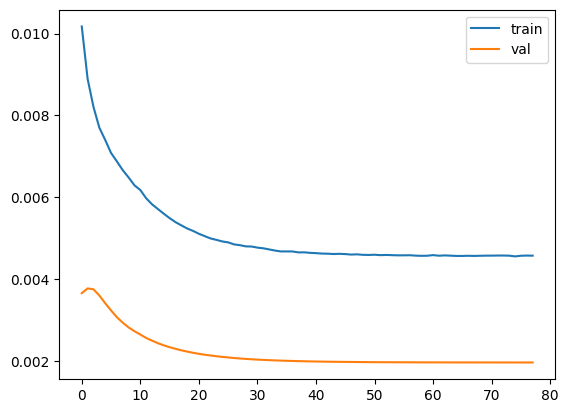

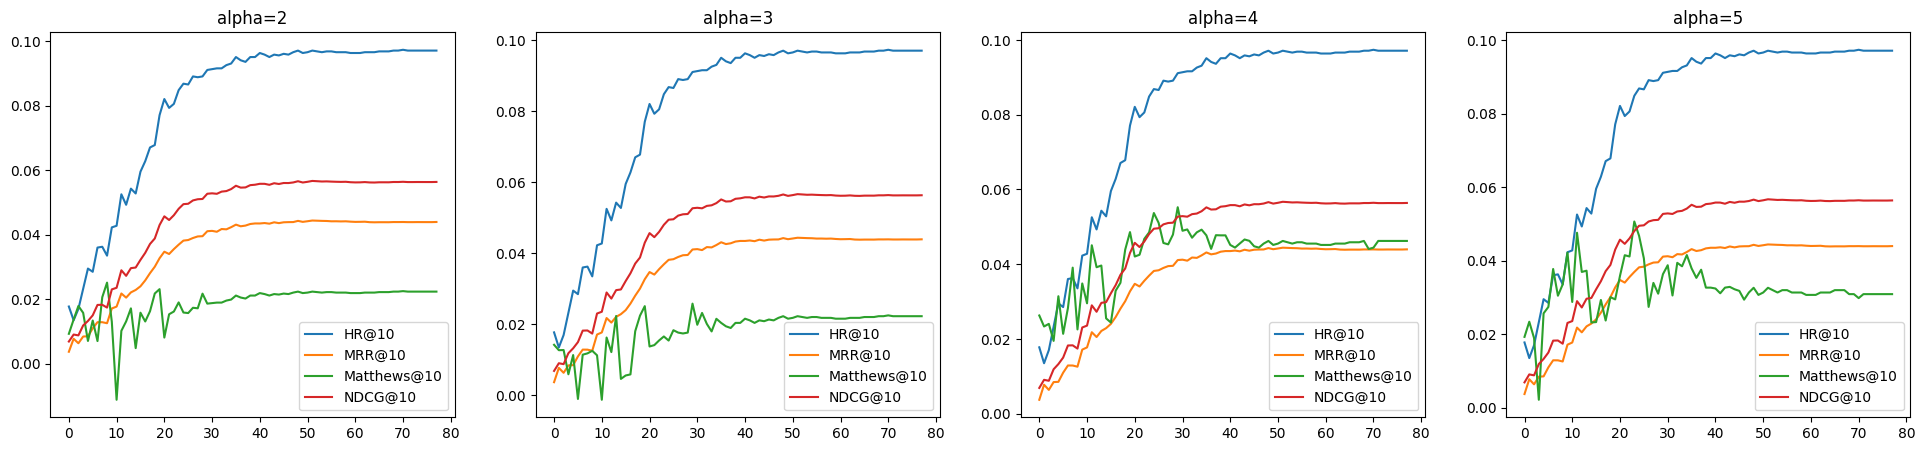

Test loss: 0.0020553243812173605
Train loss: 0.00480302874160702
Current epoch 79


In [24]:
# Training the simpleAE
early_stop = 50
n_epochs = 1000
batch_size = 16
num_batches = int(np.ceil(user_tensor_train.shape[0] / batch_size))
h = 1024

history = []
val_history = []
hrs2 = []
mrrs2 = []
cs2 = []
ndcgs2 = []

hrs3 = []
mrrs3 = []
cs3 = []
ndcgs3 = []

hrs4 = []
mrrs4 = []
cs4 = []
ndcgs4 = []

hrs5 = []
mrrs5 = []
cs5 = []
ndcgs5 = []

prev_matt2 = [0]
prev_matt3 = [0]
prev_matt4 = [0]
prev_matt5 = [0]

user_tensor_val = prepare_tensor(testset_valid, data_description).to_dense().to(device)
val_num_batches = int(np.ceil(user_tensor_val.shape[0] / batch_size))

user_tensor_test = prepare_tensor(testset, data_description).to_dense().to(device)
test_num_batches = int(np.ceil(user_tensor_test.shape[0] / batch_size))

for epoch in range(1, n_epochs+1):
    train_loss = 0

    for batch in train_dataloader:
        optimizer.zero_grad()

        input_tensor, target = batch
        input_tensor, target = input_tensor.to_dense().to(device), target.to_dense().to(device)

        output = bae(input_tensor)
        target.require_grad = False # we don't use it in training

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()

    scheduler.step()
    history.append(train_loss / num_batches)

    test_loss = 0
    scores = torch.zeros((testset_valid.userid.nunique(), data_description['n_items']))

    with torch.no_grad():
        for batch in range(val_num_batches):
            input_tensor = user_tensor_val[batch * batch_size: (batch+1) * batch_size].to(device)
            target = input_tensor.clone()

            output = bae(input_tensor)
            target.require_grad = False

            test_loss += criterion(output, target)
            scores[batch * batch_size: (batch+1) * batch_size] = output.clone()

    scores = scores.detach().cpu().numpy()
    val_loss = test_loss / val_num_batches
    val_history.append(val_loss.item())

    downvote_seen_items(scores, testset_valid, data_description)

    prev_matt2 = predict_and_check(scores, holdout_valid, data_description, hrs2, mrrs2, cs2, ndcgs2, 2, prev_matt2, epoch)
    prev_matt3 = predict_and_check(scores, holdout_valid, data_description, hrs3, mrrs3, cs3, ndcgs3, 3, prev_matt3, epoch)
    prev_matt4 = predict_and_check(scores, holdout_valid, data_description, hrs4, mrrs4, cs4, ndcgs4, 4, prev_matt4, epoch)
    prev_matt5 = predict_and_check(scores, holdout_valid, data_description, hrs5, mrrs5, cs5, ndcgs5, 5, prev_matt5, epoch)

    if len(prev_matt2) >= early_stop and len(prev_matt3) >= early_stop and len(prev_matt4) >= early_stop and len(prev_matt5) >= early_stop:
        print(f'Current epoch {epoch}')
        break

    clear_output()
    print('Epoch', epoch)
    plt.plot(history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.show()
    
    hrs = [hrs2, hrs3, hrs4, hrs5]
    mrrs = [mrrs2, mrrs3, mrrs4, mrrs5]
    cs = [cs2, cs3, cs4, cs5]
    ndcgs = [ndcgs2, ndcgs3, ndcgs4, ndcgs5]

    fig = plt.figure(figsize=(24,5))
    axes = fig.subplots(nrows=1, ncols=4)
    for i in range(4):
        axes[i].set_title(f'alpha={i+2}')
        axes[i].plot(hrs[i], label='HR@10')
        axes[i].plot(mrrs[i], label='MRR@10')
        axes[i].plot(cs[i], label='Matthews@10')
        axes[i].plot(ndcgs[i], label='NDCG@10')
        axes[i].legend()
        
    plt.show()
    
    print('Test loss:', val_history[-min(early_stop, epoch)])
    print('Train loss:', history[-min(early_stop, epoch)])

In [25]:
check_test(bae, criterion, user_tensor_test, testset, holdout, data_description, test_num_batches, 2, batch_size=16, dcg=True)
check_test(bae, criterion, user_tensor_test, testset, holdout, data_description, test_num_batches, 3, batch_size=16, dcg=True)
check_test(bae, criterion, user_tensor_test, testset, holdout, data_description, test_num_batches, 4, batch_size=16, dcg=True)
check_test(bae, criterion, user_tensor_test, testset, holdout, data_description, test_num_batches, 5, batch_size=16, dcg=True)

Results for alpha=2


HR@5    MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.021719  0.01127    0.023319  0.013847  0.020989   0.00073   0.010945   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.000325    0.013424    0.000423    0.012144

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.03194  0.012581     0.033717  0.017099   0.030845   0.001095   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.012211     0.00037     0.016562     0.000537     0.014253

HR@20   MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.053477  0.01403     0.046134  0.022486   0.051287    0.00219   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.013589     0.00044     0.021679     0.000807     0.011487

Results for alpha=3


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.043804  0.025062    0.090046  0.029678  0.041431  0.002373   0.023642   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.001421    0.028021    0.001657    0.031876

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.06461  0.027808     0.124773  0.036376   0.060595   0.004015   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.026167    0.001641     0.034186      0.00219     0.032105

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.095638  0.029957     0.170402  0.044215   0.088885   0.006753   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.028125    0.001832     0.041333     0.002883     0.030491

Results for alpha=4


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.043804  0.025062    0.090046  0.029678  0.038146  0.005658   0.021811   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.003252     0.02583    0.003848    0.040855

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.06461  0.027808     0.124773  0.036376   0.055485   0.009126   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.024073    0.003735     0.031387     0.004989     0.042326

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.095638  0.029957     0.170402  0.044215   0.081037   0.014601   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.025845    0.004112     0.037847     0.006369     0.043189

Results for alpha=5


HR@5     MRR@5  Coverage@5    NCDG@5  HR_pos@5  HR_neg@5  MRR_pos@5  \
5  0.041066  0.023185    0.080557  0.027586  0.027377  0.013689   0.015848   

   MRR_neg@5  NCDG_pos@5  NDCG_neg@5  Matthews@5  
5   0.007337    0.018688    0.008897    0.026089

HR@10    MRR@10  Coverage@10   NCDG@10  HR_pos@10  HR_neg@10  \
10  0.06242  0.026047     0.108217  0.034503   0.041613   0.020807   

    MRR_pos@10  MRR_neg@10  NCDG_pos@10  NDCG_neg@10  Matthews@10  
10    0.017777    0.008269     0.023321     0.011182     0.032529

HR@20    MRR@20  Coverage@20   NCDG@20  HR_pos@20  HR_neg@20  \
20  0.091075  0.027991     0.151221  0.041693    0.06096   0.030115   

    MRR_pos@20  MRR_neg@20  NCDG_pos@20  NDCG_neg@20  Matthews@20  
20    0.019096    0.008895     0.028184     0.013509     0.041638